Индустрия такси в в мире (особенно в крупных городах) развивается быстро как никогда. В своем проекте я хочу попредсказывать среднее время поездки на такси

In [152]:
%pip3 install folium --user #установка фолиума, для работы с картами
%pip3 install squarify --user #и для treemap

UsageError: Line magic function `%pip3` not found.


In [221]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime
import folium
from sklearn.model_selection import train_test_split
import squarify #загрузка необходимых библиотек

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 12
np.random.seed(0) #красивые параметры для графиков

## Поиск и первичный анализ данных

В качестве обучающей выборки буду использовать данные с сайте [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview). Это были соревнования, где как раз надо было предсказать длительность поездки. Это несколько облегчает задачу, так как данные уже предобработаны и собержат много полезных переменных. 
В этот датасет организаторы также добавили колонку `dropoff_datetime`, так как эта выборка - обучающая. Её, очевидно, нельзя использовать для построения предсказаний, поэтому её буду удалять. 

*данные можно просто скачать с сайта. Но я, конечно, еще и selenium'ом воспользовалась. Да, он тут только, чтобы на соседнюю вкладку перейти

In [309]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

driver = webdriver.Chrome()
driver.get("https://www.kaggle.com/c/nyc-taxi-trip-duration/overview")

button = driver.find_element(By.CSS_SELECTOR, "button.sc-idkuTu:nth-child(2)")
button.click()

In [128]:
df = pd.read_csv('_train.csv') #считали необходимые данные 
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) #в эту колонку записаны время началапоездки, для удобства переводим её в формат дата-время
df.drop(columns = ['dropoff_datetime'], inplace = True) #удаляю время высадки
df

id  vendor_id     pickup_datetime  passenger_count  \
0        id2875421          2 2016-03-14 17:24:55                1   
1        id2377394          1 2016-06-12 00:43:35                1   
2        id3858529          2 2016-01-19 11:35:24                1   
3        id3504673          2 2016-04-06 19:32:31                1   
4        id2181028          2 2016-03-26 13:30:55                1   
...            ...        ...                 ...              ...   
1458639  id2376096          2 2016-04-08 13:31:04                4   
1458640  id1049543          1 2016-01-10 07:35:15                1   
1458641  id2304944          2 2016-04-22 06:57:41                1   
1458642  id2714485          1 2016-01-05 15:56:26                1   
1458643  id1209952          1 2016-04-05 14:44:25                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
0              -73.982155        40.767937         -73.964630   
1              -73.980415        40.738564         -73.999481   
2              -73.979027        40.763939         -74.005333   
3              -74.010040        40.719971         -74.012268   
4              -73.973053        40.793209         -73.972923   
...                   ...              ...                ...   
1458639        -73.982201        40.745522         -73.994911   
1458640        -74.000946        40.747379         -73.970184   
1458641        -73.959129        40.768799         -74.004433   
1458642        -73.982079        40.749062         -73.974632   
1458643        -73.979538        40.781750         -73.972809   

         dropoff_latitude store_and_fwd_flag  trip_duration  
0               40.765602                  N            455  
1               40.731152                  N            663  
2               40.710087                  N           2124  
3               40.706718                  N            429  
4               40.782520                  N            435  
...                   ...                ...            ...  
1458639         40.740170                  N            778  
1458640         40.796547                  N            655  
1458641         40.707371                  N            764  
1458642         40.757107                  N            373  
1458643         40.790585                  N            198  

[1458644 rows x 10 columns]

Колонка trip_duration содержит целевое значение, которое я хочу научиться предсказывать. Самое простое, что можно для начала оценить по ней: минимальную, максимальную и средную длительность поездки. Прям как задание из лабораторной;) Давайте посмотрим

In [129]:
tr_dr = df['trip_duration']
print(f'Минимальная длительность поездки: {tr_dr.min()}; максимальная длительность поездки: {tr_dr.max()}; среднее {tr_dr.mean()}')

Минимальная длительность поездки: 1; максимальная длительность поездки: 3526282; среднее 959.4922729603659


Также можем посмотреть на гистограмму распределения

Text(0.5, 1.0, 'Распределение таргетируемой длительности поездки')

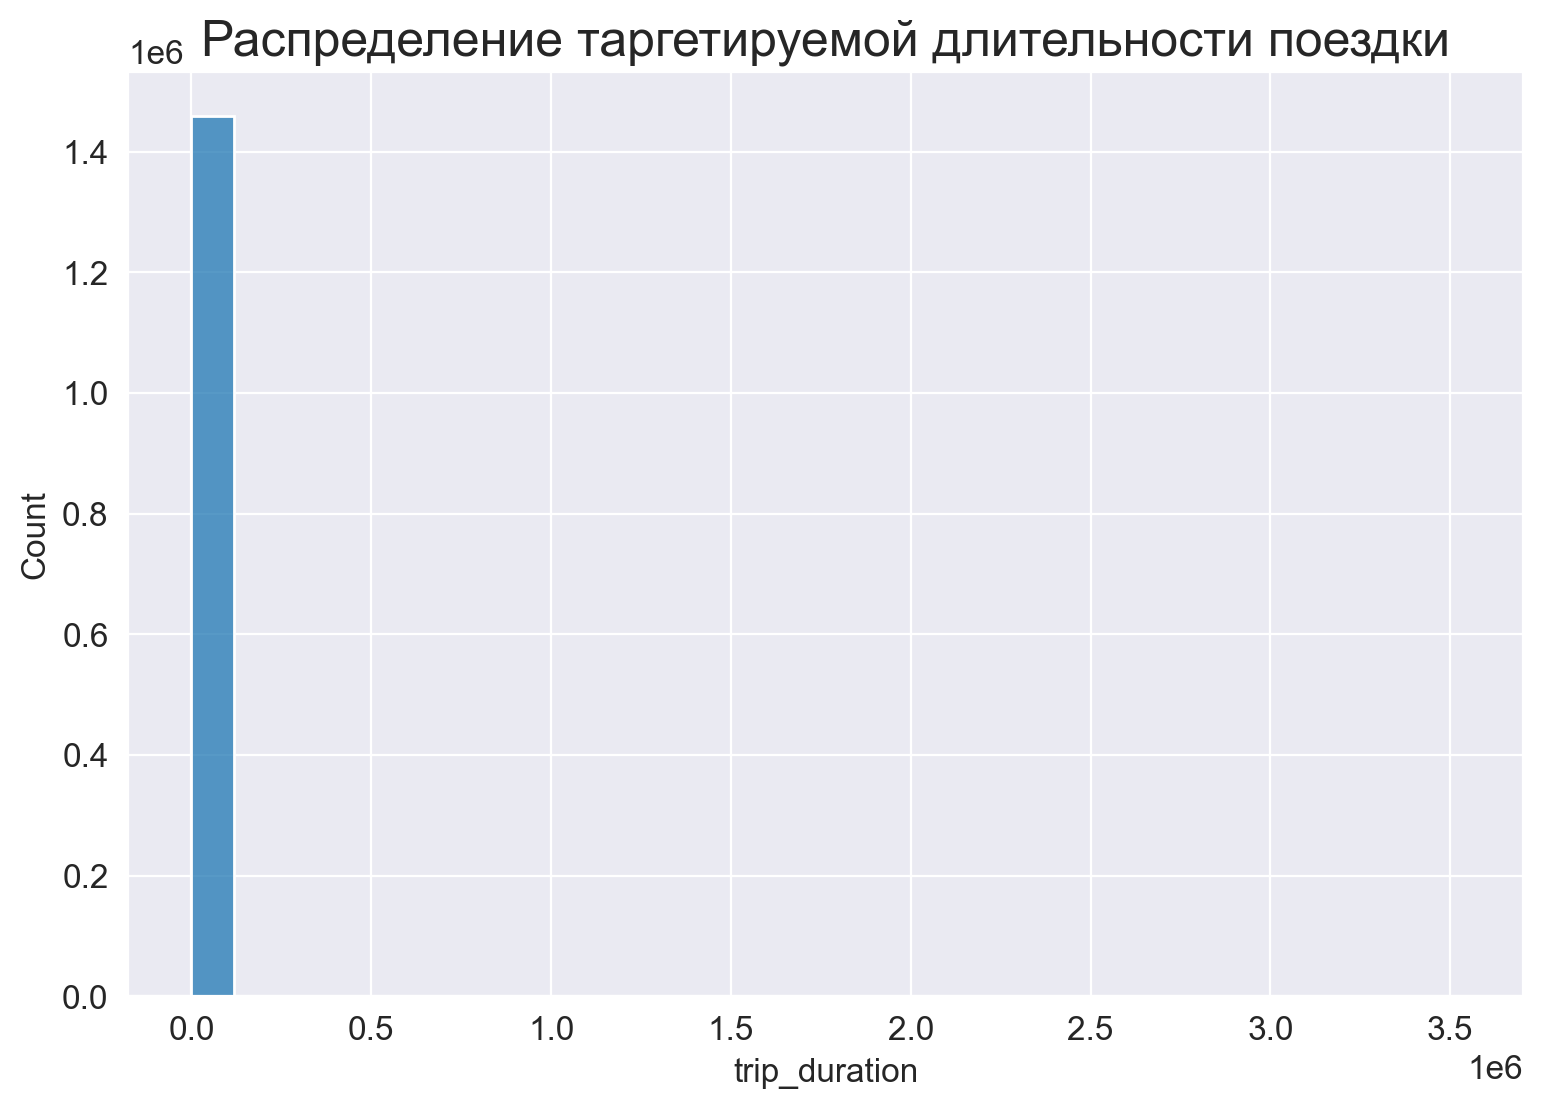

In [130]:
fig, ax = plt.subplots(figsize = (9, 6))

sns.histplot(data = df,
             x = 'trip_duration',
             bins=30,
             ax=ax);
plt.title('Распределение таргетируемой длительности поездки', fontsize = 18)

Можем заметить, что в данных есть выбросы. Большинство значений переменной лежит около нуля, при этом максимум равняется миллиону. Попробуем очистить данные от выбросов. Построим диаграммы без маленьких хвостов. 

Text(0.5, 1.0, 'Распределение таргетируемой длительности поездки')

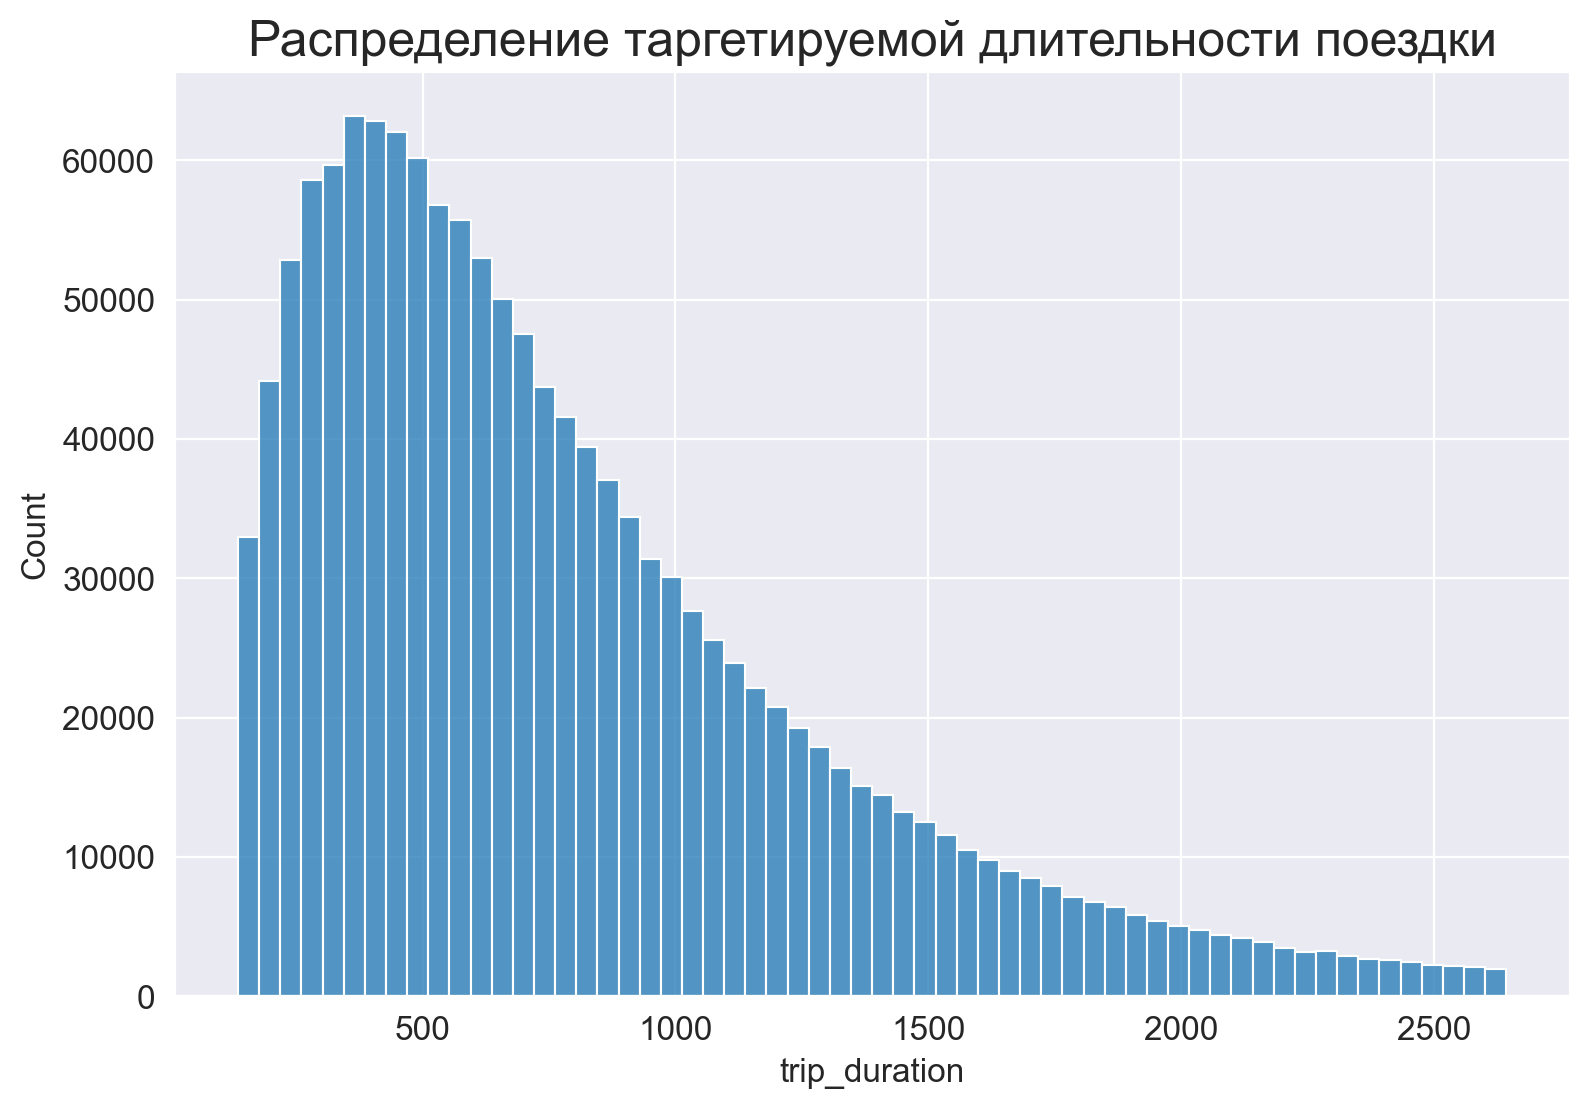

In [131]:
small_quant = df['trip_duration'].quantile(q = 0.025) #квантиль 2.5%
big_quant = df['trip_duration'].quantile(q = 0.975) #квантиль 97.5%

modified_trip_duration = df[(df['trip_duration'] >= small_quant) & (df['trip_duration'] <= big_quant)]['trip_duration']

fig, ax = plt.subplots(figsize = (9, 6))

sns.histplot(data = modified_trip_duration,
             bins=60,
             ax=ax);
plt.title('Распределение таргетируемой длительности поездки', fontsize = 18)

Напоминает гамма-распределение🤔

В оригинальном соревновании в качестве метрики использовали RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

Это делает распределение более однородным, как раз убирает сильные выбросы, которые как мы отметили ранее есть. А также RMSLE смотрит на ошибки в относительных значениях, в то время как более распространенная RMSE смотрит на них в абсолютных.

Можно заметить, что если логарифмировать целевую переменную, то вместо RMSLE можно оценивать среднеквадратичную ошибку (MSE). Т.к.:
$$\text{RMSLE}(x, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\ln{(y_i + 1)} - \ln{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\ln{(y_i + 1)} - \ln{(e^{\ln(a(x_i))} - 1 + 1)}\big)^2} =$$
 $$ = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\ln{(y_i + 1)} - (\ln(a(x_i)))^2}
 = \text{MSE}(x, ln(y), \ln(a)) $$

Теперь логарифмируем таргетную переменную и кладем в новую колонку `log_trip_duration`

Text(0.5, 1.0, 'Распределение логарифма таргетируемой длительности поездки')

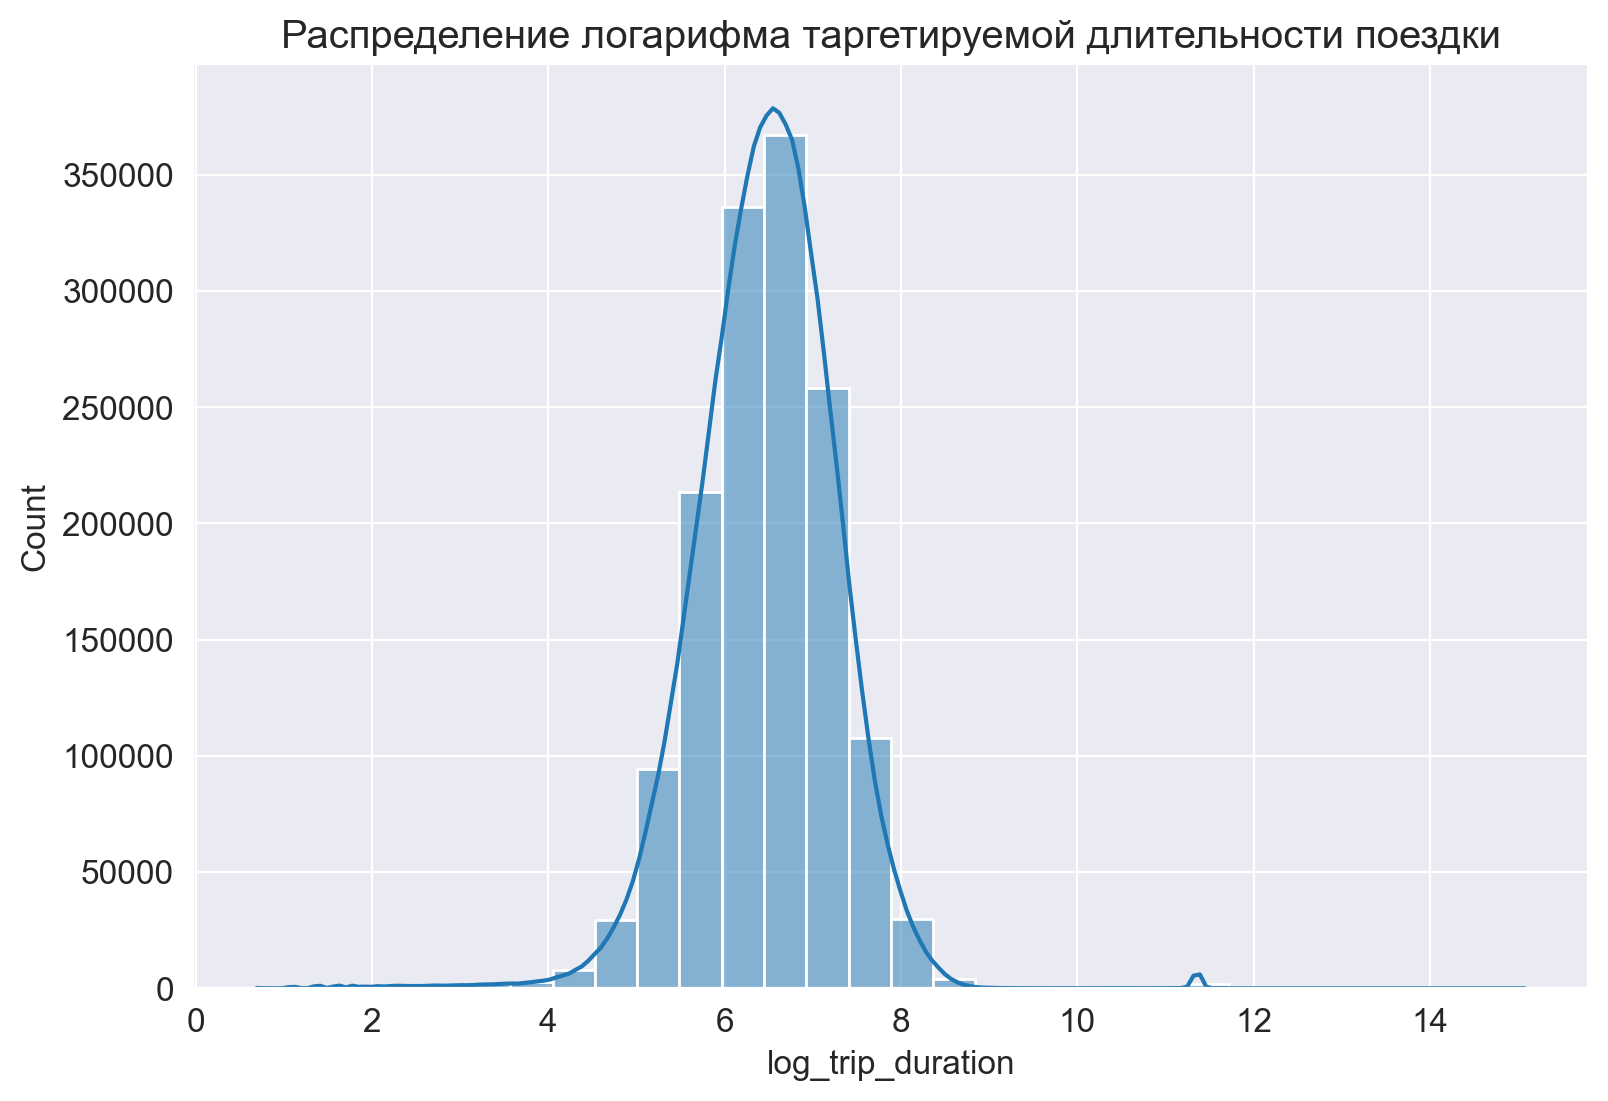

In [132]:
df['log_trip_duration'] = np.log1p(df['trip_duration']) #логарифмируем
df.drop(columns = ['trip_duration'], axis = 1, inplace = True) #удаляем исходную колонку

fig, ax = plt.subplots(figsize = (9, 6))

sns.histplot(data = df,
             x = 'log_trip_duration',
             kde=True,
             bins=30,
             ax=ax);
plt.title('Распределение логарифма таргетируемой длительности поездки')

Как мы знаем из теор вера: лучшее константное предсказание - его среднее значение. На него будем ориентироваться в нашем мини-исследовании

In [135]:
print(np.sqrt(np.sum((df['log_trip_duration'] - np.array(np.mean(df['log_trip_duration'])))**2) / len(df['log_trip_duration'])))

0.7957592365411509


## Внимательно смотрим на `pickup_datetime`

Для начала, посмотрим на количество поездок в зависимости от дня в году.

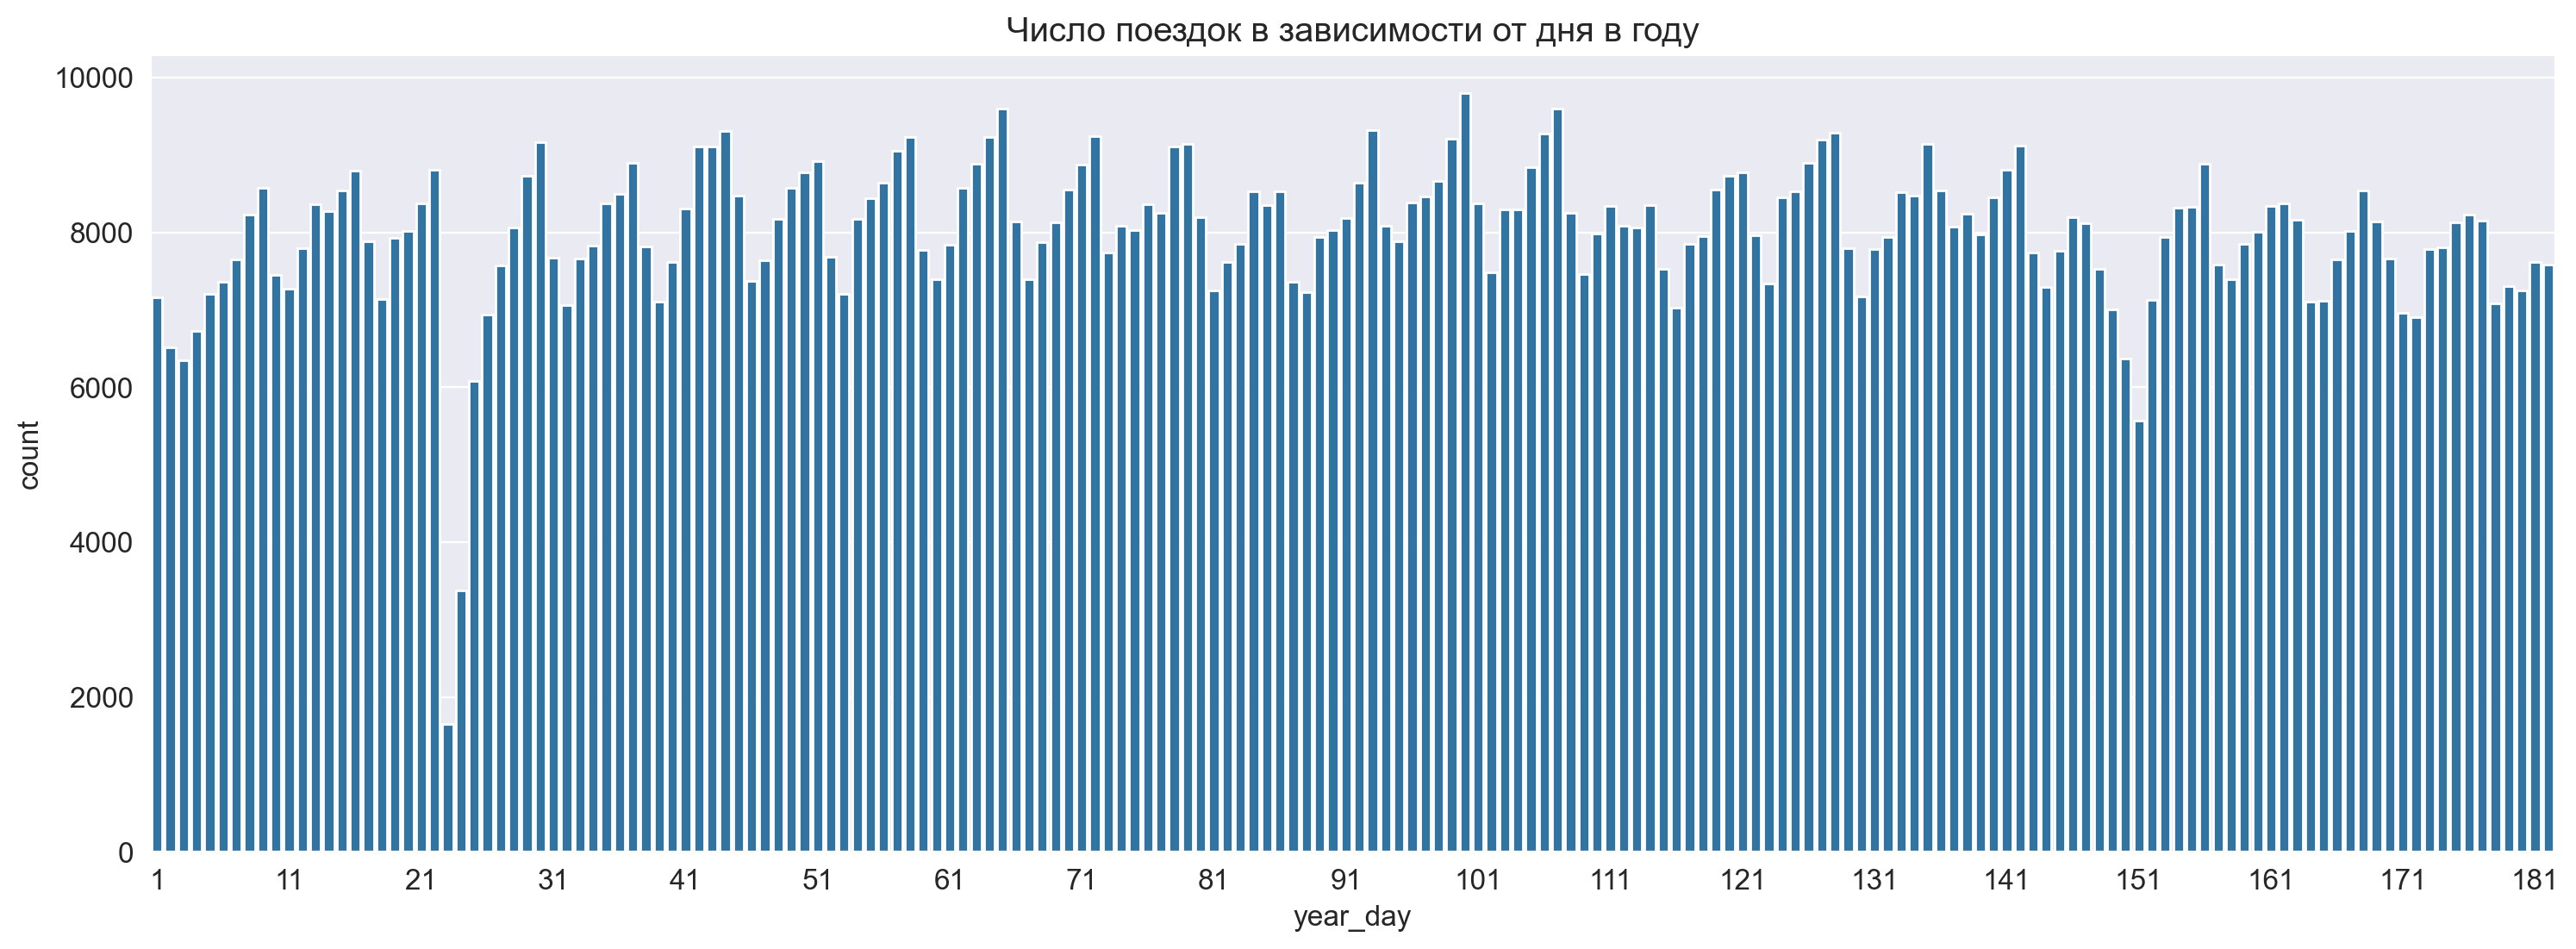

In [147]:
df['year_day'] = df['pickup_datetime'].dt.day_of_year
plt.figure(figsize = (18, 6))
ax = sns.countplot(df, x = 'year_day')
plt.title('Число поездок в зависимости от дня в году')
xticks, labels = plt.xticks()
plt.xticks(xticks[::10], labels[::10])
plt.show()

Видим два аномальных падения в числе поездок. Узнаем, в какие даты это было. Но сначала treemap

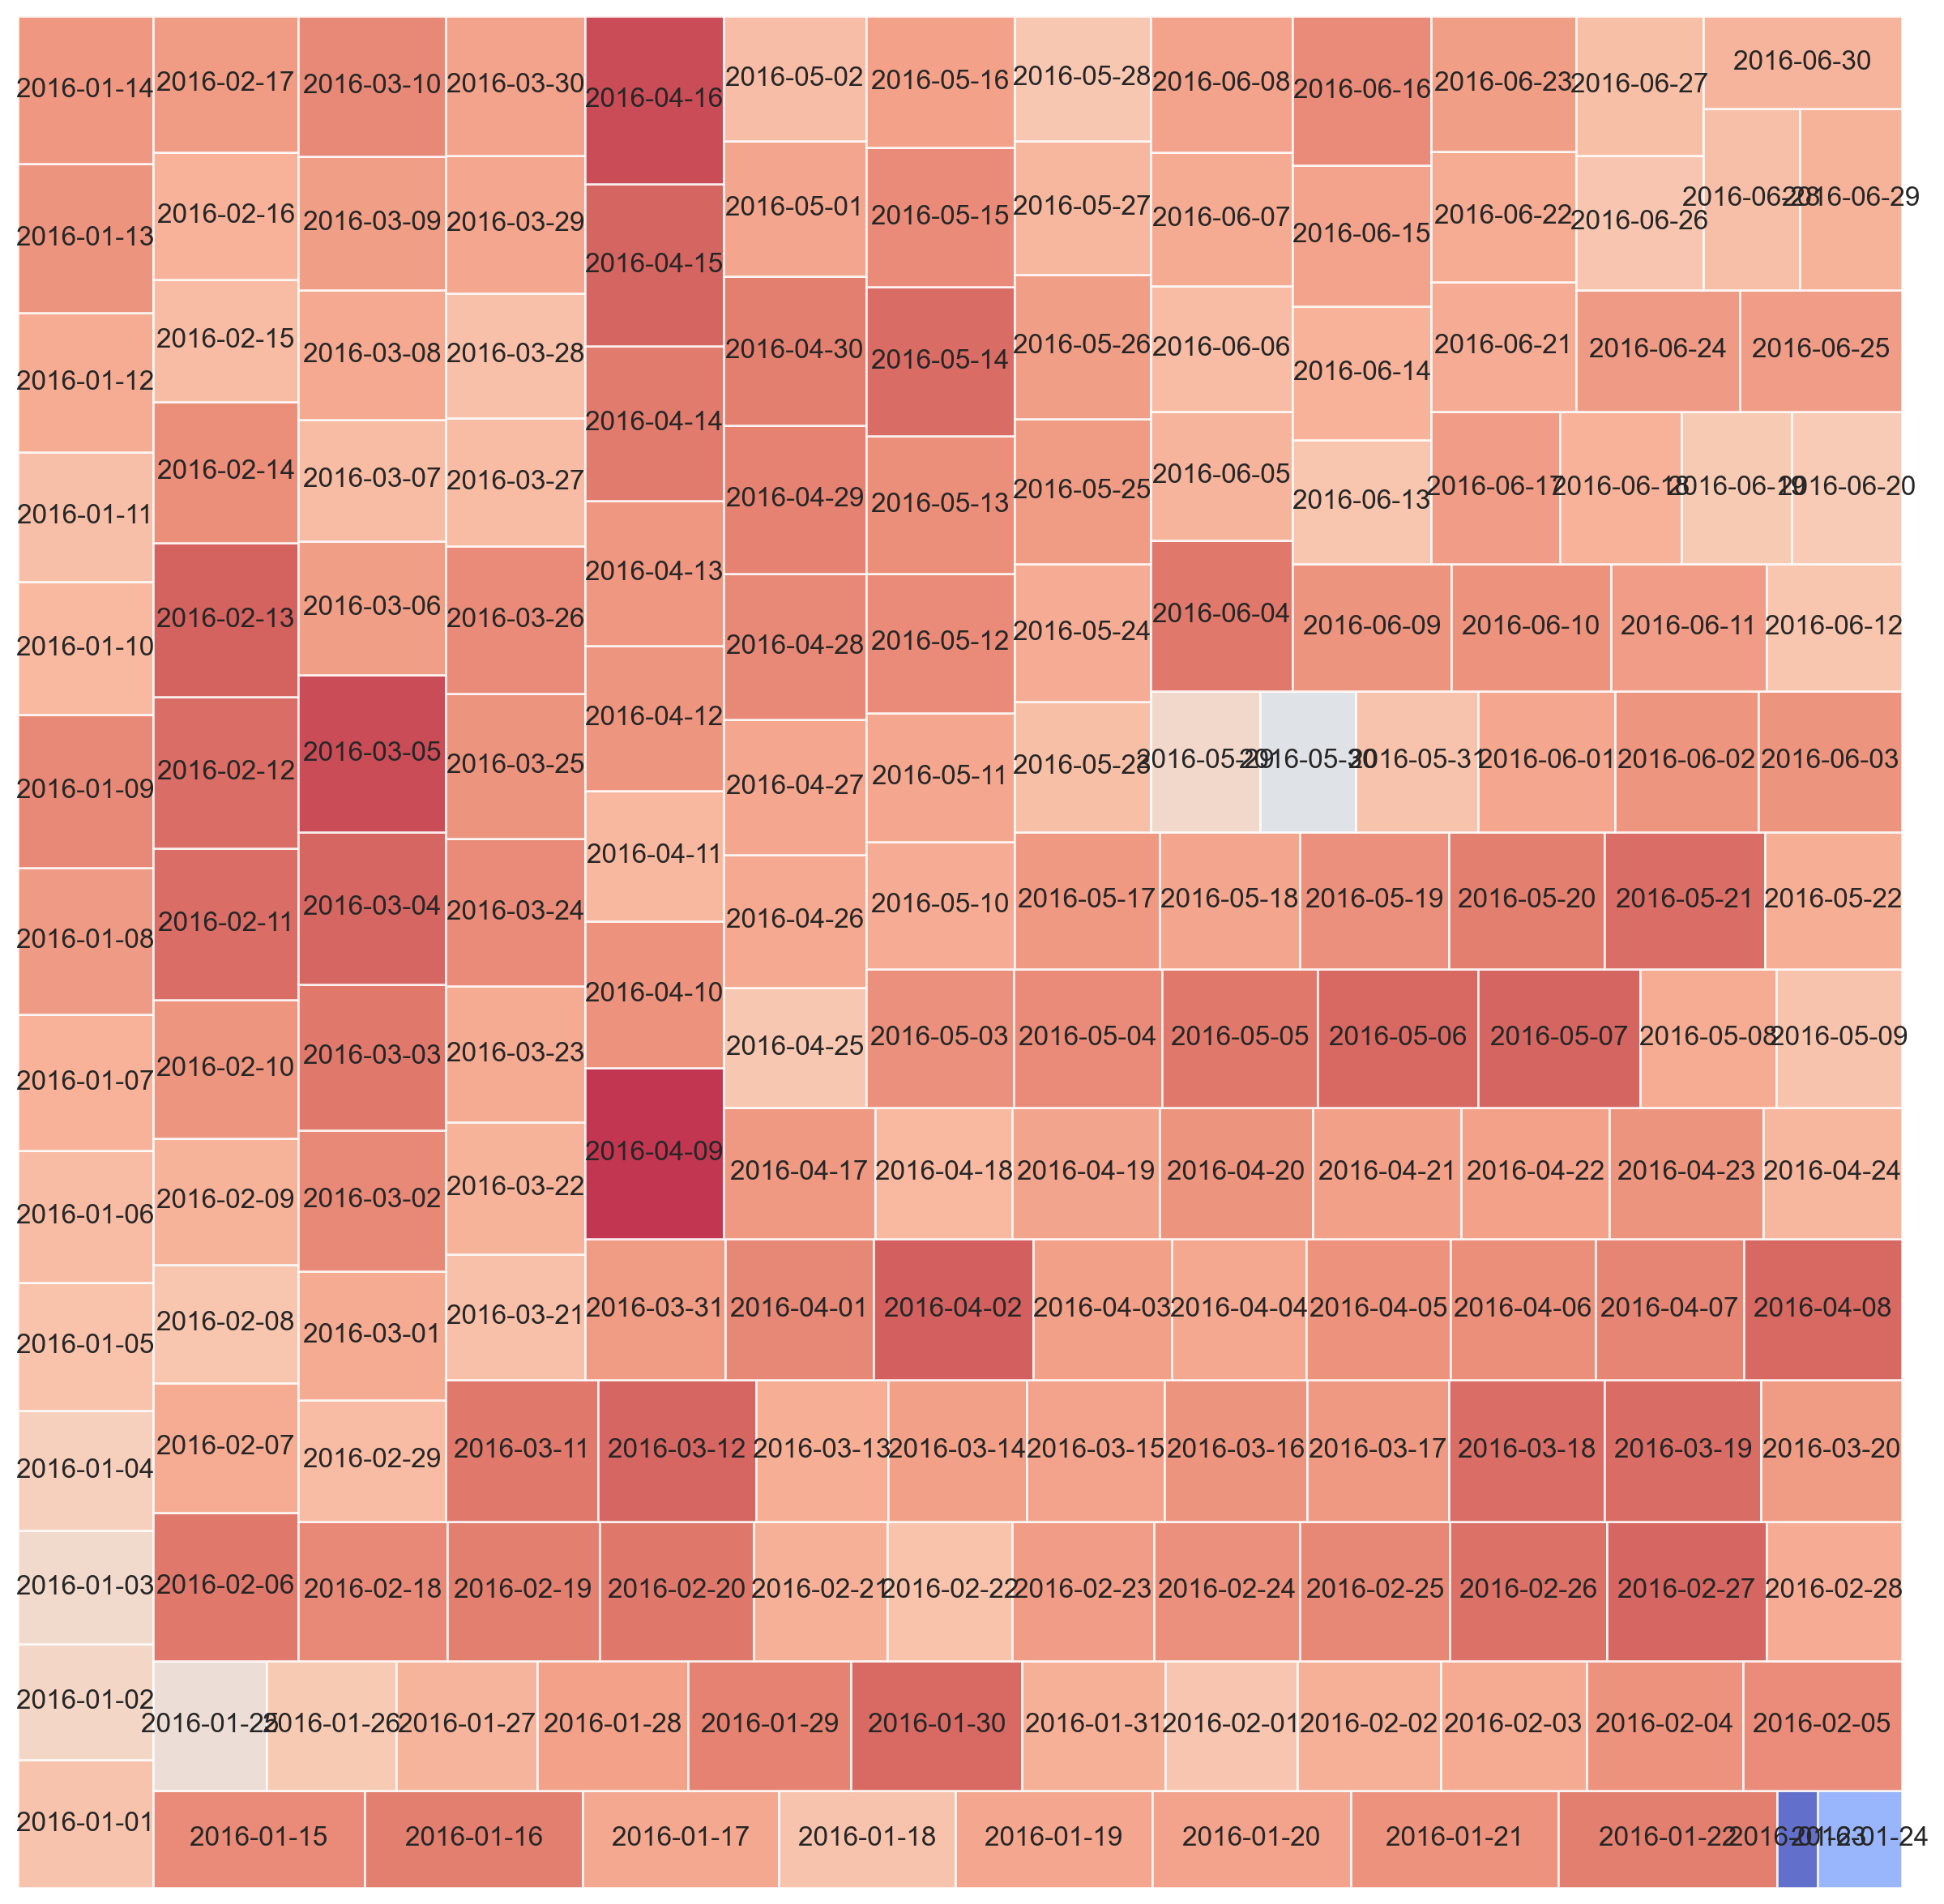

In [176]:
#Адаптировано отсюда: https://python-graph-gallery.com/202-treemap-with-colors-mapped-on-values/
df['pickup_date'] = df['pickup_datetime'].dt.date
nm_date = df.groupby(['pickup_date']).count()['id'].reset_index().rename(columns={'id':'trips_number'}) 
cmap = matplotlib.cm.coolwarm #Чем краснее цвет, тем больше поездок в этот день
my_v = nm_date['trips_number']
mini=min(my_v)
maxi=max(my_v)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
plt.figure(figsize = (15, 15))
squarify.plot(sizes = my_v, alpha=.8, color=colors, label = nm_date['pickup_date'])
plt.axis('off')
plt.show()

In [179]:
tr_n_d = df['pickup_date'].value_counts(ascending=True)
print('Дни с аномально маленьким числом поездок: ')
for i in range(4):
    print(tr_n_d.keys()[i])

Дни с аномально маленьким числом поездок: 
2016-01-23
2016-01-24
2016-05-30
2016-01-25


Первый период проседания в кол-ве поездок. В это время на Северо-Востоке США была сильная снежная буря, в Нью-Йорке выпало до 60 см снега, из-за чего много где объявили чрезвычаной положение.Источник: https://ria.ru/20160123/1364032228.html

Второй период - день Поминования (memorial day weekend), поэтому многие дорогие были перекрыты.

В общем спады вызваны какими-то внешними факторами

Теперь посмотрим на кол-во поездок в зависимости от дня недели и времени суток.

In [184]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday.astype('object')
df['pickup_hour'] = df['pickup_datetime'].dt.hour

d_n_tr = df.groupby(['day_of_week']).count()['id'].reset_index().rename(columns={'id':'trips_number'}) #кол-во поездок от дня недели
h_n_tr = df.groupby(['pickup_hour']).count()['id'].reset_index().rename(columns={'id':'trips_number'}) #кол-во поездок от времени суток

([<matplotlib.axis.XTick at 0x7fab474476a0>,
 [Text(0, 0, 'ПН'),
  Text(1, 0, 'ВТ'),
  Text(2, 0, 'СР'),
  Text(3, 0, 'ЧТ'),
  Text(4, 0, 'ПТ'),
  Text(5, 0, 'СБ'),
  Text(6, 0, 'ВС')])

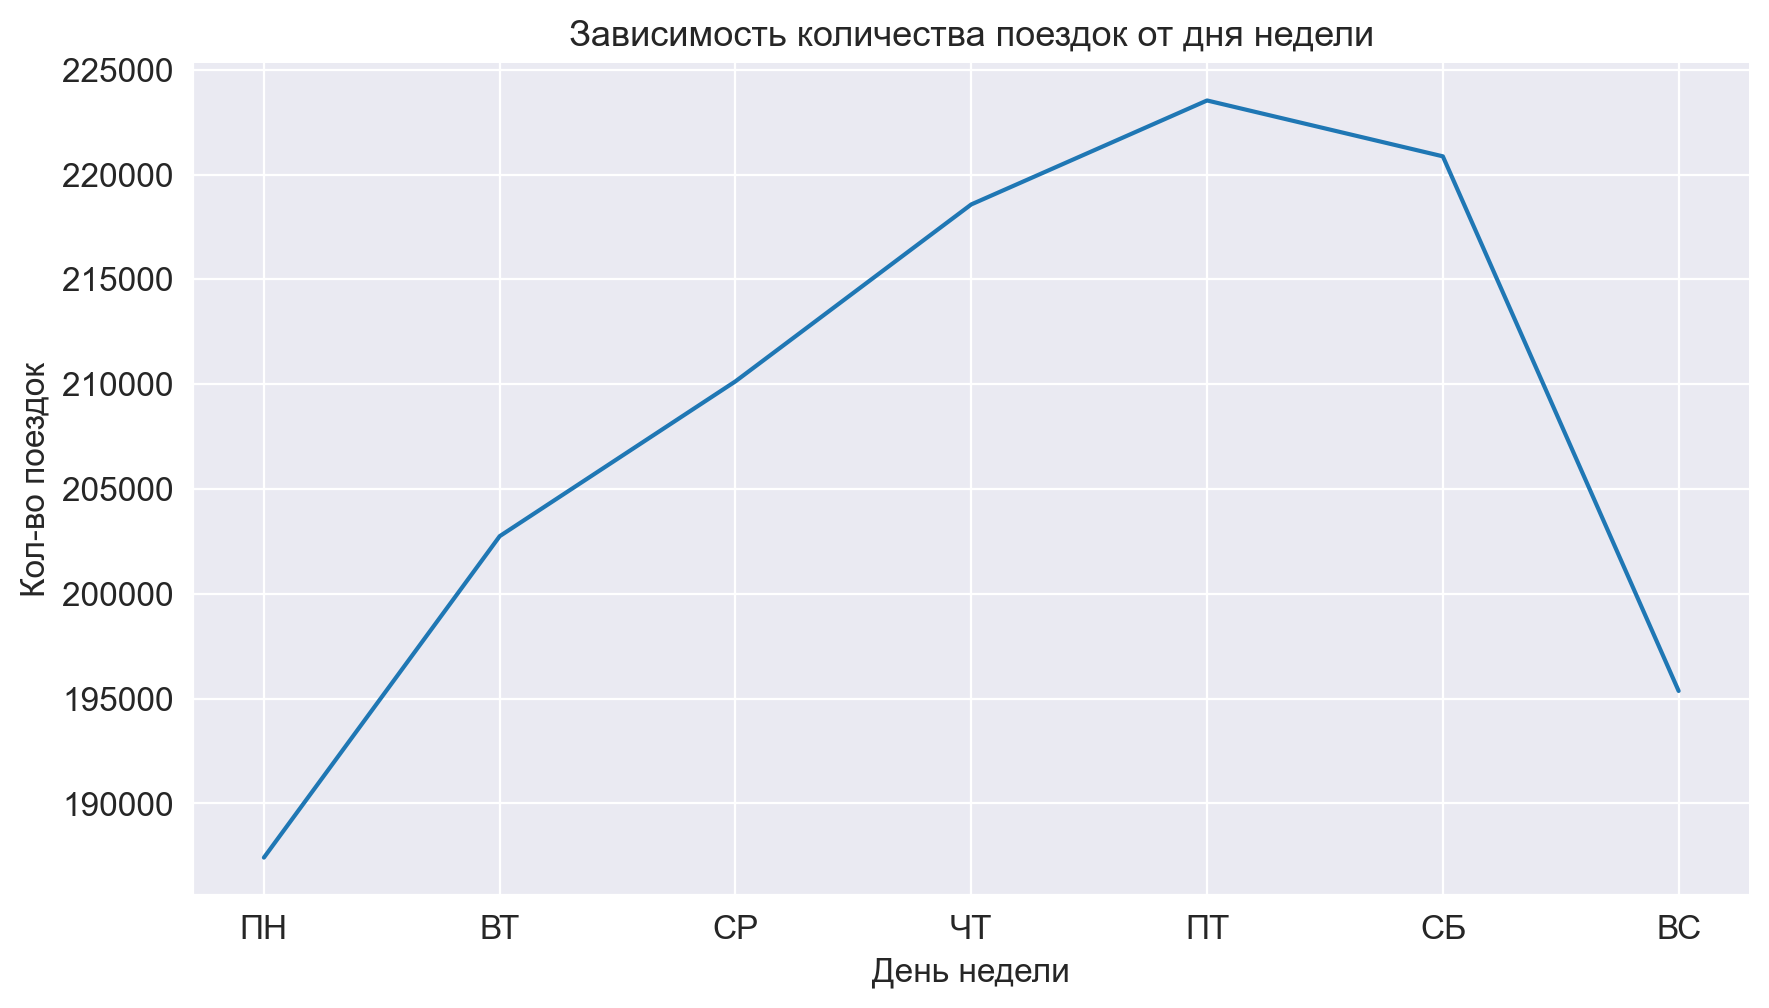

In [185]:
sns.relplot(data = d_n_tr,
            x = 'day_of_week',
            y = 'trips_number',
            kind = 'line',
            height = 5,
            aspect = 1.8)

plt.title('Зависимость количества поездок от дня недели', fontsize = 13)
plt.xlabel('День недели')
plt.ylabel('Кол-во поездок')
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = ['ПН', 'ВТ', 'СР', 'ЧТ', 'ПТ', 'СБ', 'ВС'])


Text(-10.805555555555541, 0.5, 'Кол-во поездок')

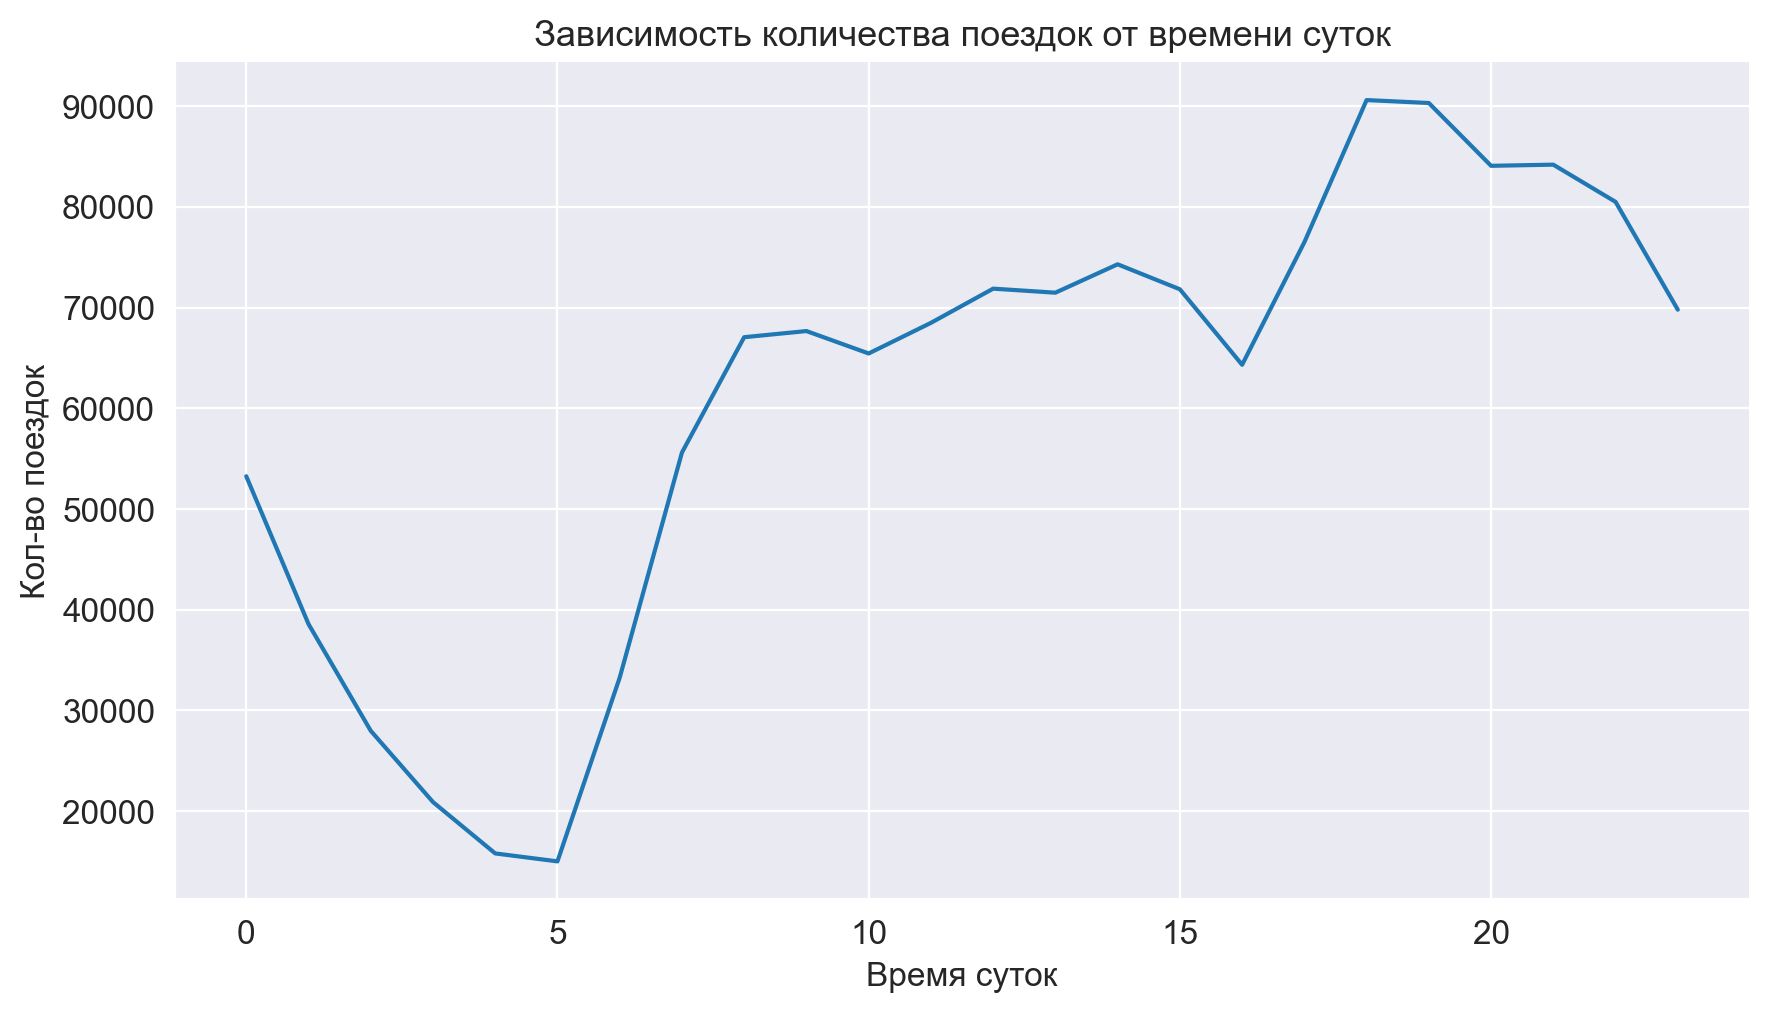

In [187]:
sns.relplot(data = h_n_tr,
            x = 'pickup_hour',
            y = 'trips_number',
            kind = 'line',
            height = 5,
            aspect = 1.8)

plt.title('Зависимость количества поездок от времени суток', fontsize = 13)
plt.xlabel('Время суток')
plt.ylabel('Кол-во поездок')

Вернемся к логарифмам. Разобьем выборку на обучающую и тестовую в отношении 7:3.  По обучающей выборке нарисуем график зависимости среднего логарифма времени поездки от дня недели, часа в сутках и дня в году.

In [253]:
df['month'] = df['pickup_datetime'].dt.month_name()

In [254]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 42)

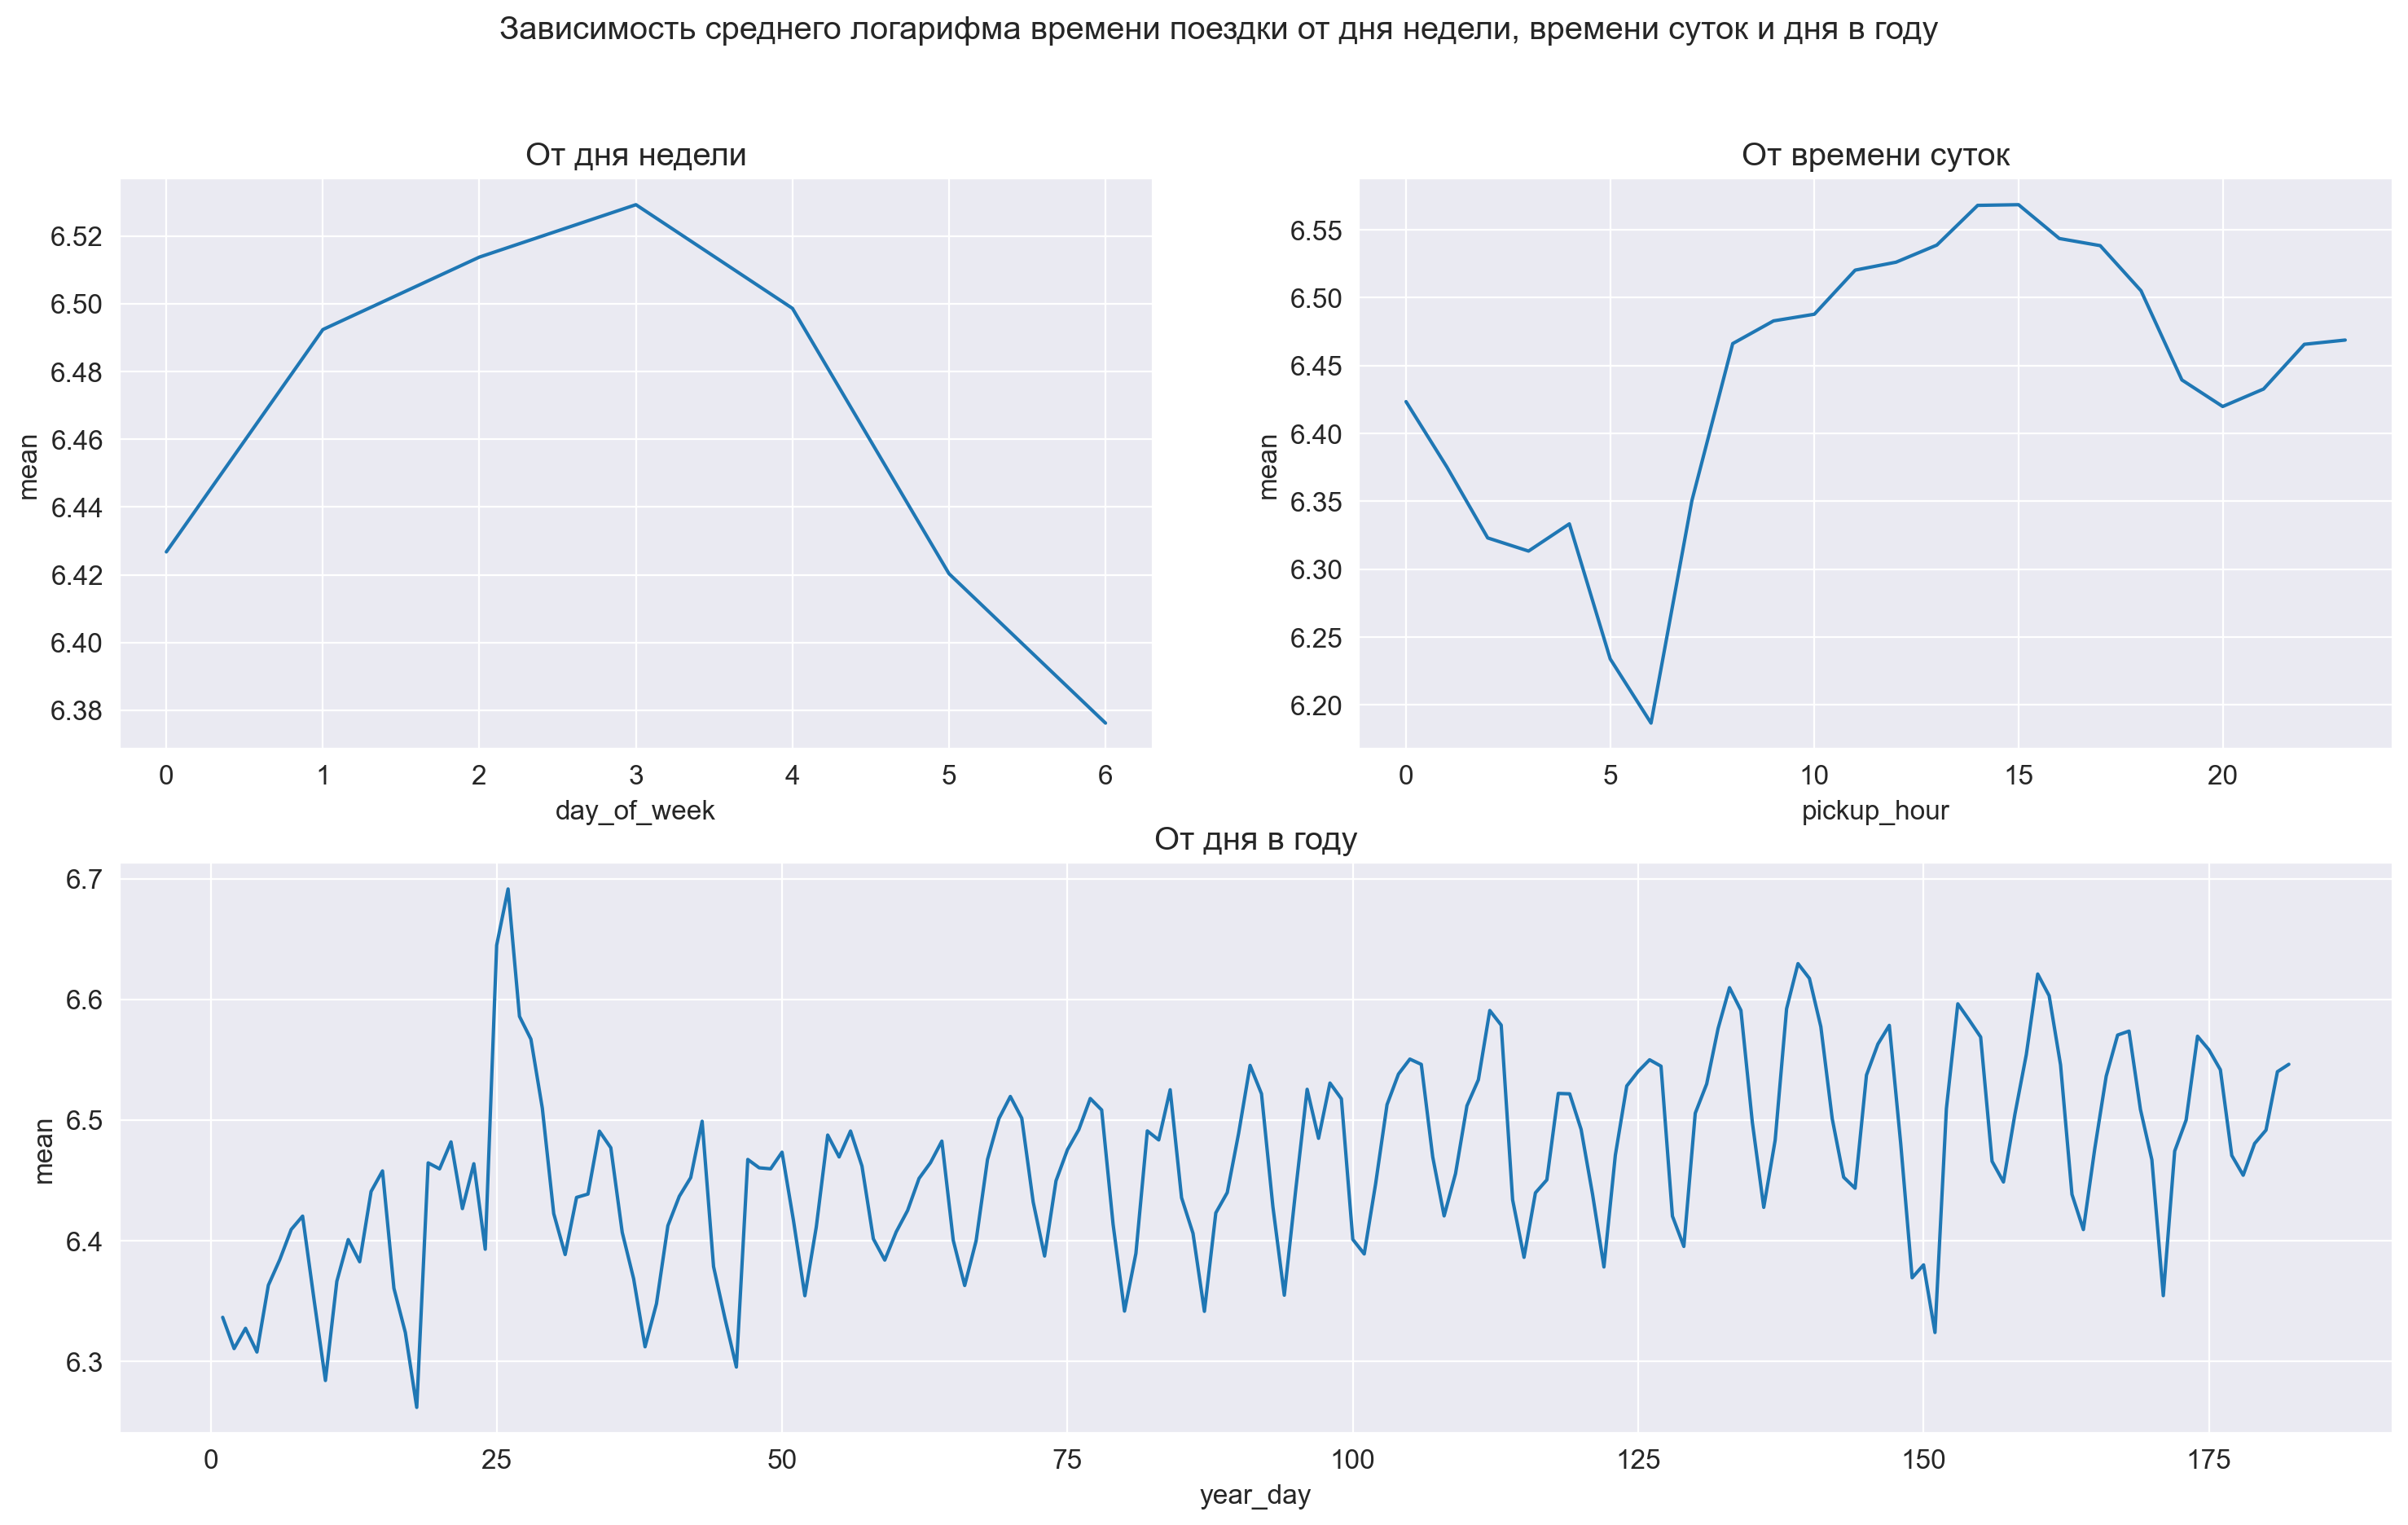

In [255]:
weekday_trip_duration = df_train.groupby(by = 'day_of_week')['log_trip_duration'].agg(['mean']).reset_index()
hourly_trip_duration = df_train.groupby(by = 'pickup_hour')['log_trip_duration'].agg(['mean']).reset_index()
daily_trip_duration = df_train.groupby(by = 'year_day')['log_trip_duration'].agg(['mean']).reset_index()

fig = plt.figure(figsize = (18, 10))
fig.suptitle('Зависимость среднего логарифма времени поездки от дня недели, времени суток и дня в году')

ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)
ax_3 = fig.add_subplot(2, 1, 2)

ax_1.set(title = 'От дня недели')
ax_2.set(title = 'От времени суток')
ax_3.set(title = 'От дня в году')

sns.lineplot(data = weekday_trip_duration,
            x = 'day_of_week',
            y = 'mean',
            ax = ax_1)

sns.lineplot(data = hourly_trip_duration,
            x = 'pickup_hour',
            y = 'mean',
            ax = ax_2)

sns.lineplot(data = daily_trip_duration,
            x = 'year_day',
            y = 'mean',
            ax = ax_3)

plt.show()

Будем изучать `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. 

In [258]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [260]:
def rmsle(log1p_y_true, log1p_y_pred): 
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred)**2))
    raise NotImplementedError

X_train = df_train.loc[:, ['day_of_week', 'pickup_hour', 'month', 'year_day']]
y_train = df_train['log_trip_duration']
X_test = df_test.loc[:, ['day_of_week', 'pickup_hour', 'month', 'year_day']]
y_test = df_test['log_trip_duration']

categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
numeric_features = ['pickup_hour', 'year_day']
print(f'Категориальные признаки: {categorical_features} \n'
      f'Численные: {numeric_features}'
      )


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

ridge_pipeline = Pipeline([
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = ridge_pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))
print("Train RMSLE = %.4f" % rmsle(y_train, y_train_pred))

Категориальные признаки: ['day_of_week', 'month'] 
Численные: ['pickup_hour', 'year_day']
Test RMSLE = 0.7920
Train RMSLE = 0.7929


## Изучаем координаты

Посмотрим на распределение поездок на карте. Будем смотреть на части данных, чтобы было не слишком долго

In [218]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
  
    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [222]:
df_copy = df_train.copy()
show_circles_on_map(df_copy.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

На карте, например, явно выделяются два скопления точек, возле двух аэропортов

Время поездки t = s/v. Поэтому нам важно смотреть на пройденное расстояние. Посчитать пройденное раасстояние нельзя, но можно оценить оценить, посчитав расстояние между началом и концом поездки.

In [224]:
def haversine_array(lat1, lng1, lat2, lng2):  #функция подсчета расстояния на земле
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    earth_rad = 6371  
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * earth_rad * np.arcsin(np.sqrt(d))
    return h

In [247]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

df_train_copy['haversine'] = haversine_array(lat1 = df_train['pickup_latitude'], lng1 = df_train['pickup_longitude'], 
                                        lat2 = df_train['dropoff_latitude'], lng2 = df_train['dropoff_longitude'])
df_test_copy['haversine'] = haversine_array(lat1 = df_test['pickup_latitude'], lng1 = df_test['pickup_longitude'], 
                                        lat2 = df_test['dropoff_latitude'], lng2 = df_test['dropoff_longitude'])

df_train_copy['log_haversine'] = np.log1p(df_train_copy['haversine']) #логарифмировали расстрояние, так будет удобнее, так как частно превратиться в разность
df_test_copy['log_haversine'] = np.log1p(df_test_copy['haversine'])

Теперь оценим среднюю скорость такси

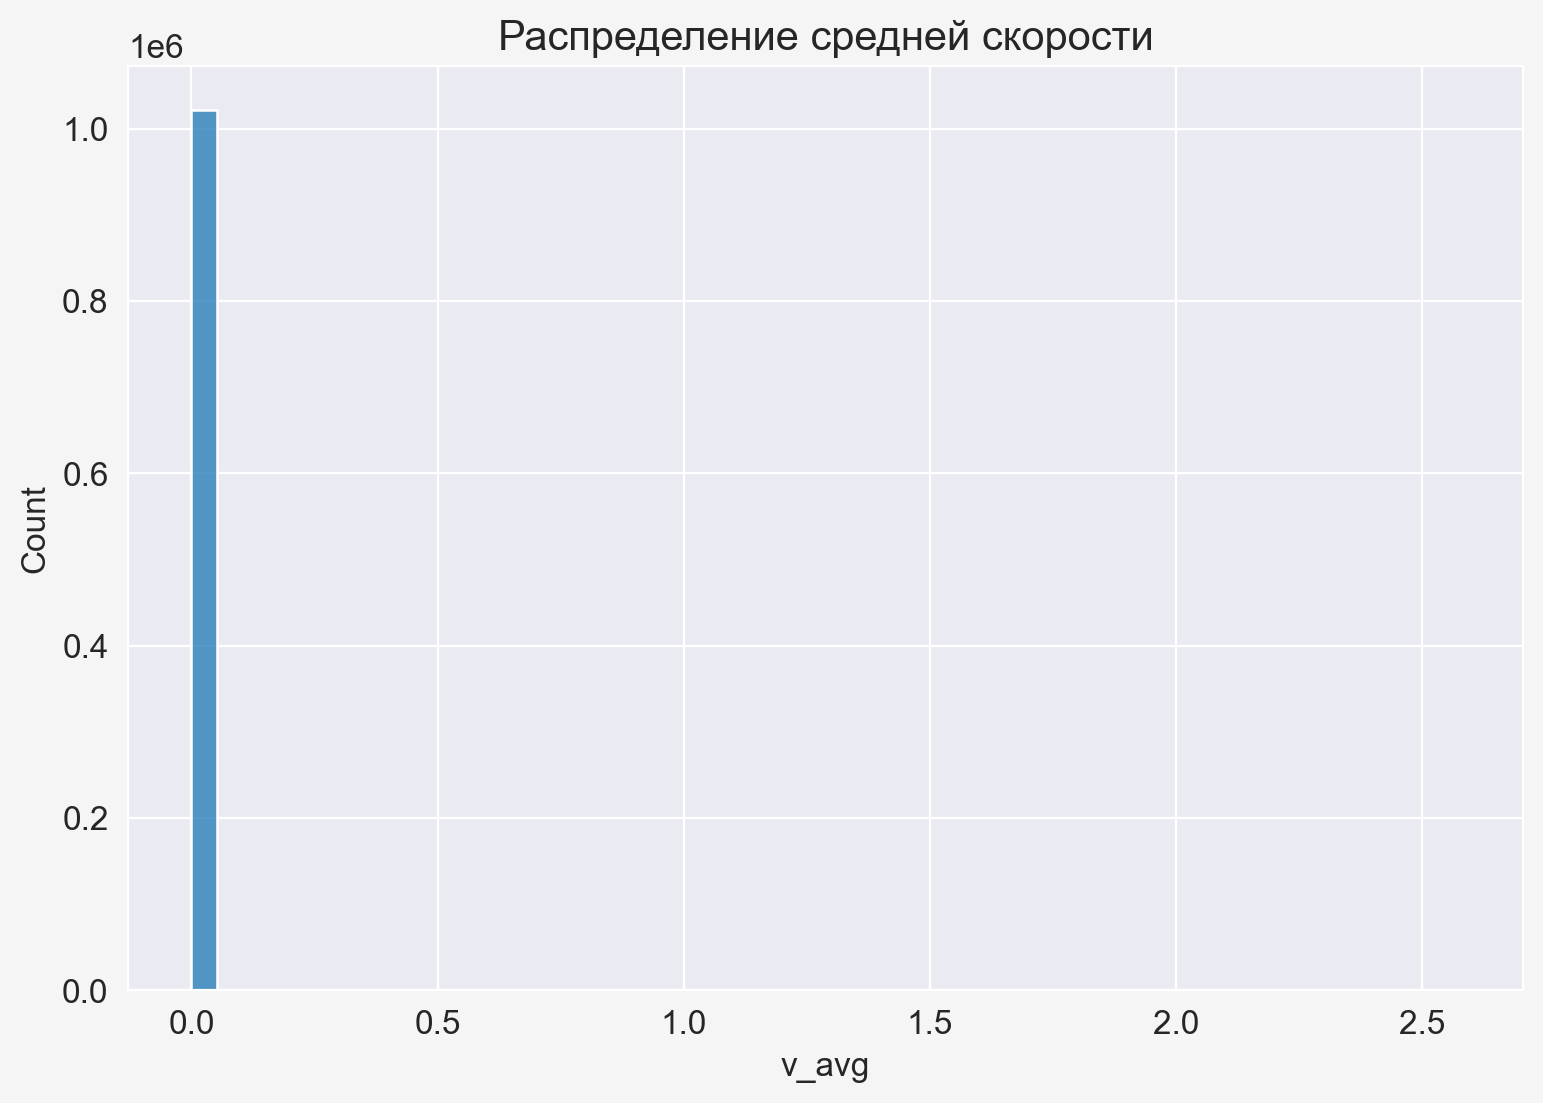

In [249]:
df_train_copy['v_avg'] = df_train_copy['haversine'] / (np.exp(df_train_copy['log_trip_duration']) - 1)

fig, ax = plt.subplots(figsize = (9, 6))

fig.set(facecolor = 'whitesmoke')
ax.set_title('Распределение средней скорости', fontsize = 15)

sns.histplot(data = df_train_copy,
             x = 'v_avg',
             bins = 50,
             ax = ax);

plt.show()

Аналогично первой части, избавимся от выбрасов и построим новую диаграмму

Text(0.5, 1.0, 'Распределение средней скорости без выбросов')

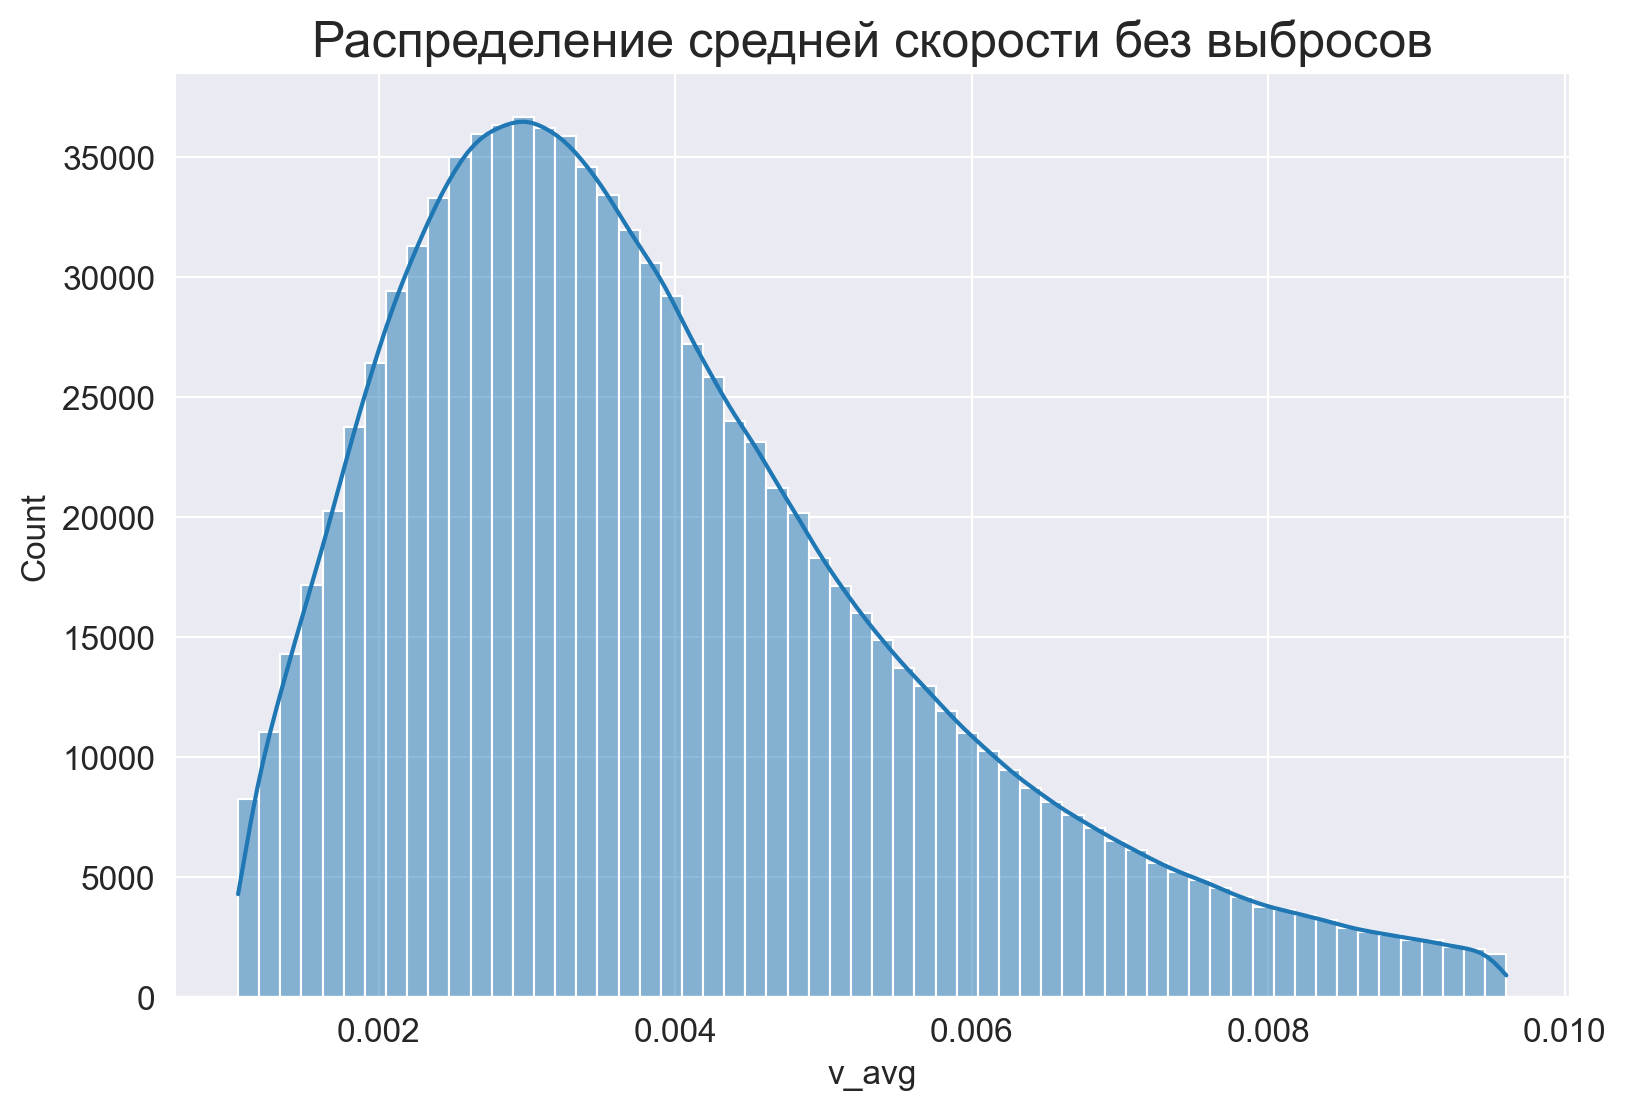

In [233]:
small_quant = df_train_copy['v_avg'].quantile(q = 0.025) #квантиль 2.5%
big_quant = df_train_copy['v_avg'].quantile(q = 0.975) #квантиль 97.5%

modified_trip_duration = df_train_copy[(df_train_copy['v_avg'] >= small_quant) & (df_train_copy['v_avg'] <= big_quant)]['v_avg']

fig, ax = plt.subplots(figsize = (9, 6))

sns.histplot(data = modified_trip_duration,
             kde=True,
             bins=60,
             ax=ax);
plt.title('Распределение средней скорости без выбросов', fontsize = 18)

Теперь для каждой пары (день недели, час суток) посчитаем медиану скоростей и покажем на heatmap.

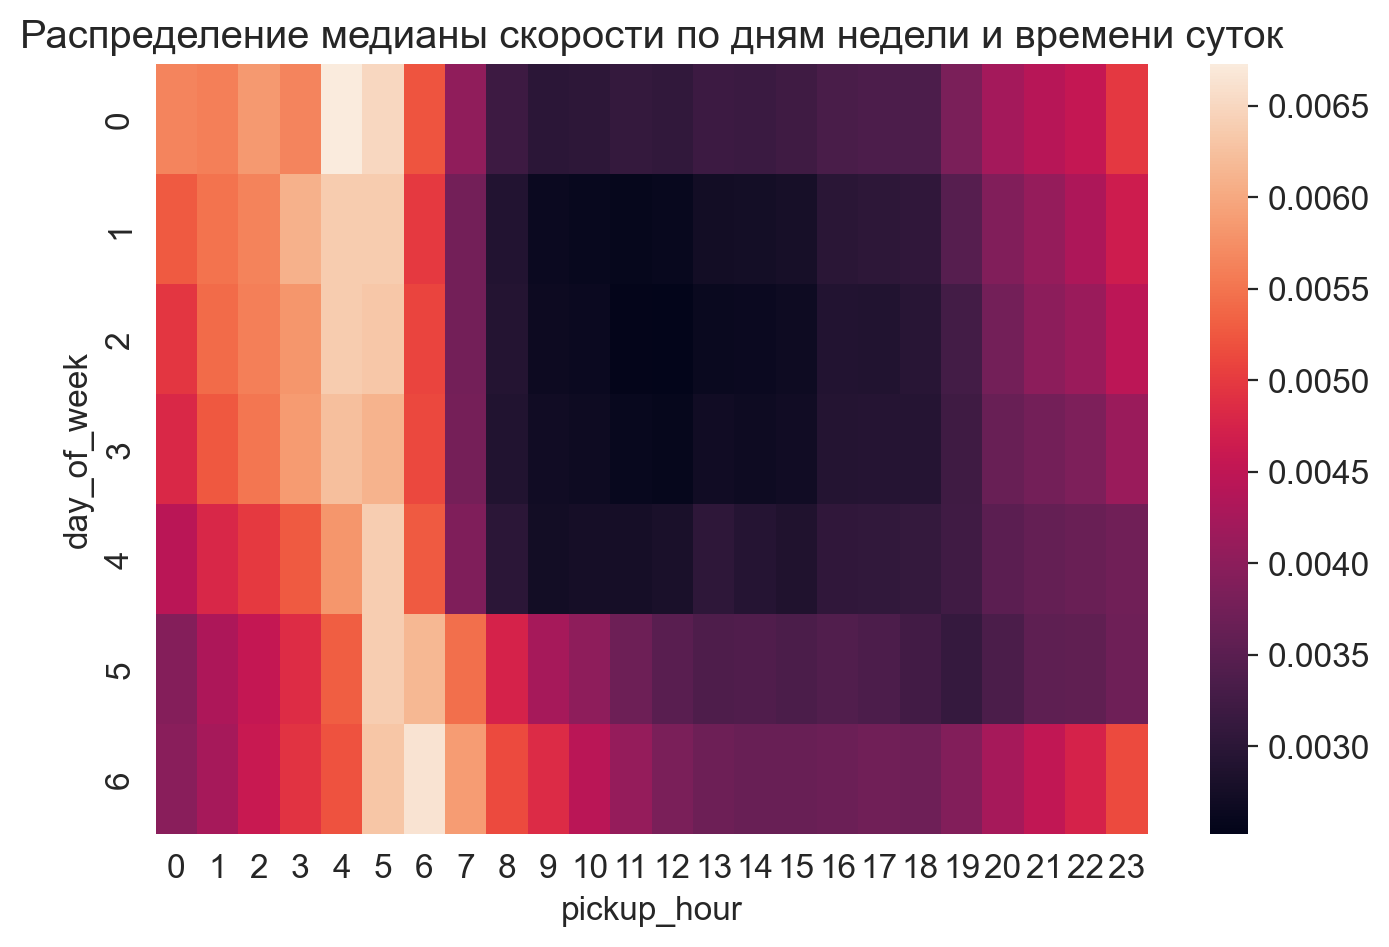

In [243]:
medians = df_train_copy[['day_of_week', 'pickup_hour', 'v_avg']].groupby(['day_of_week', 'pickup_hour']).median()
medians = medians.values.reshape(7, 24)
sns.heatmap(medians)
plt.xlabel('pickup_hour')
plt.ylabel('day_of_week')
plt.title('Распределение медианы скорости по дням недели и времени суток')
plt.show()

А теперь удалим колонку со значением скорости из датасета, потому что в скорость заложена информация о времени поездки, которая и есть наш таргет, что чревато переобучением

In [250]:
del df_train_copy['v_avg']
del df_train_copy['haversine']
del df_test_copy['haversine']

Создадим два признаки "поездка в период пробок" и "поездка на свободных дорогах". По хитмэпу видим, что скорость минимальна в будни (середина дня 8-16 часов), а маскимальна в 4-6 часов утра (в любые дни).

In [261]:
df_train_copy['traffic_time'] = ((df_train_copy['day_of_week'] <= 4) & (df_train_copy['pickup_hour'] >= 8) & (df_train_copy['pickup_hour'] <= 18)) #создаем признаки, основываясь на результатх из хитмэпа
df_test_copy['traffic_time'] = ((df_test_copy['day_of_week'] <= 4) & (df_test_copy['pickup_hour'] >= 8) & (df_test_copy['pickup_hour'] <= 18))

df_train_copy['notraffic_time'] = ((df_train_copy['pickup_hour'] >= 4) & (df_train_copy['pickup_hour'] <= 6))
df_test_copy['notraffic_time'] = ((df_test_copy['pickup_hour'] >= 4) & (df_test_copy['pickup_hour'] <= 6))

df_train_copy = df_train_copy.astype({'traffic_time': int, 'notraffic_time': int}) #делаем их индикаторами
df_test_copy = df_test_copy.astype({'traffic_time': int, 'notraffic_time': int})

Также добавим еще два признака: была ли поездка из какого-то из аэропортов, была ли поездка в какой-то из аэропортов. К таким поездкам будем относить те, что находятся в радиусе 2 км от  координат, которые указаны в Википедии как точка размещения аэропорта.

In [263]:
kennedy_lat, kennedy_lng = 40.60639, -73.77889
laguardia_lat, laguardia_lng = 40.7769, -73.874 #координаты аэропортов

df_train_copy.loc[:, 'pickup_kennedy'] = (haversine_array(df_train_copy['pickup_latitude'].values, df_train_copy['pickup_longitude'].values, kennedy_lat, kennedy_lng) < 2).astype(int)
df_train_copy.loc[:, 'dropoff_kennedy'] = (haversine_array(df_train_copy['dropoff_latitude'].values, df_train_copy['dropoff_longitude'].values, kennedy_lat, kennedy_lng) < 2).astype(int)

df_train_copy.loc[:, 'pickup_laguardia'] = (haversine_array(df_train_copy['pickup_latitude'].values, df_train_copy['pickup_longitude'].values, laguardia_lat, laguardia_lng) < 2).astype(int)
df_train_copy.loc[:, 'dropoff_laguardia'] = (haversine_array(df_train_copy['dropoff_latitude'].values, df_train_copy['dropoff_longitude'].values, laguardia_lat, laguardia_lng) < 2).astype(int)

#то же самое для теста

df_test_copy.loc[:, 'pickup_kennedy'] = (haversine_array(df_test_copy['pickup_latitude'].values, df_test_copy['pickup_longitude'].values, kennedy_lat, kennedy_lng) < 2).astype(int)
df_test_copy.loc[:, 'dropoff_kennedy'] = (haversine_array(df_test_copy['dropoff_latitude'].values, df_test_copy['dropoff_longitude'].values, kennedy_lat, kennedy_lng) < 2).astype(int)

df_test_copy.loc[:, 'pickup_laguardia'] = (haversine_array(df_test_copy['pickup_latitude'].values, df_test_copy['pickup_longitude'].values, laguardia_lat, laguardia_lng) < 2).astype(int)
df_test_copy.loc[:, 'dropoff_laguardia'] = (haversine_array(df_test_copy['dropoff_latitude'].values, df_test_copy['dropoff_longitude'].values, laguardia_lat, laguardia_lng) < 2).astype(int)

А теперь посмотрим на ящики с усами логарифма от времени поездки.

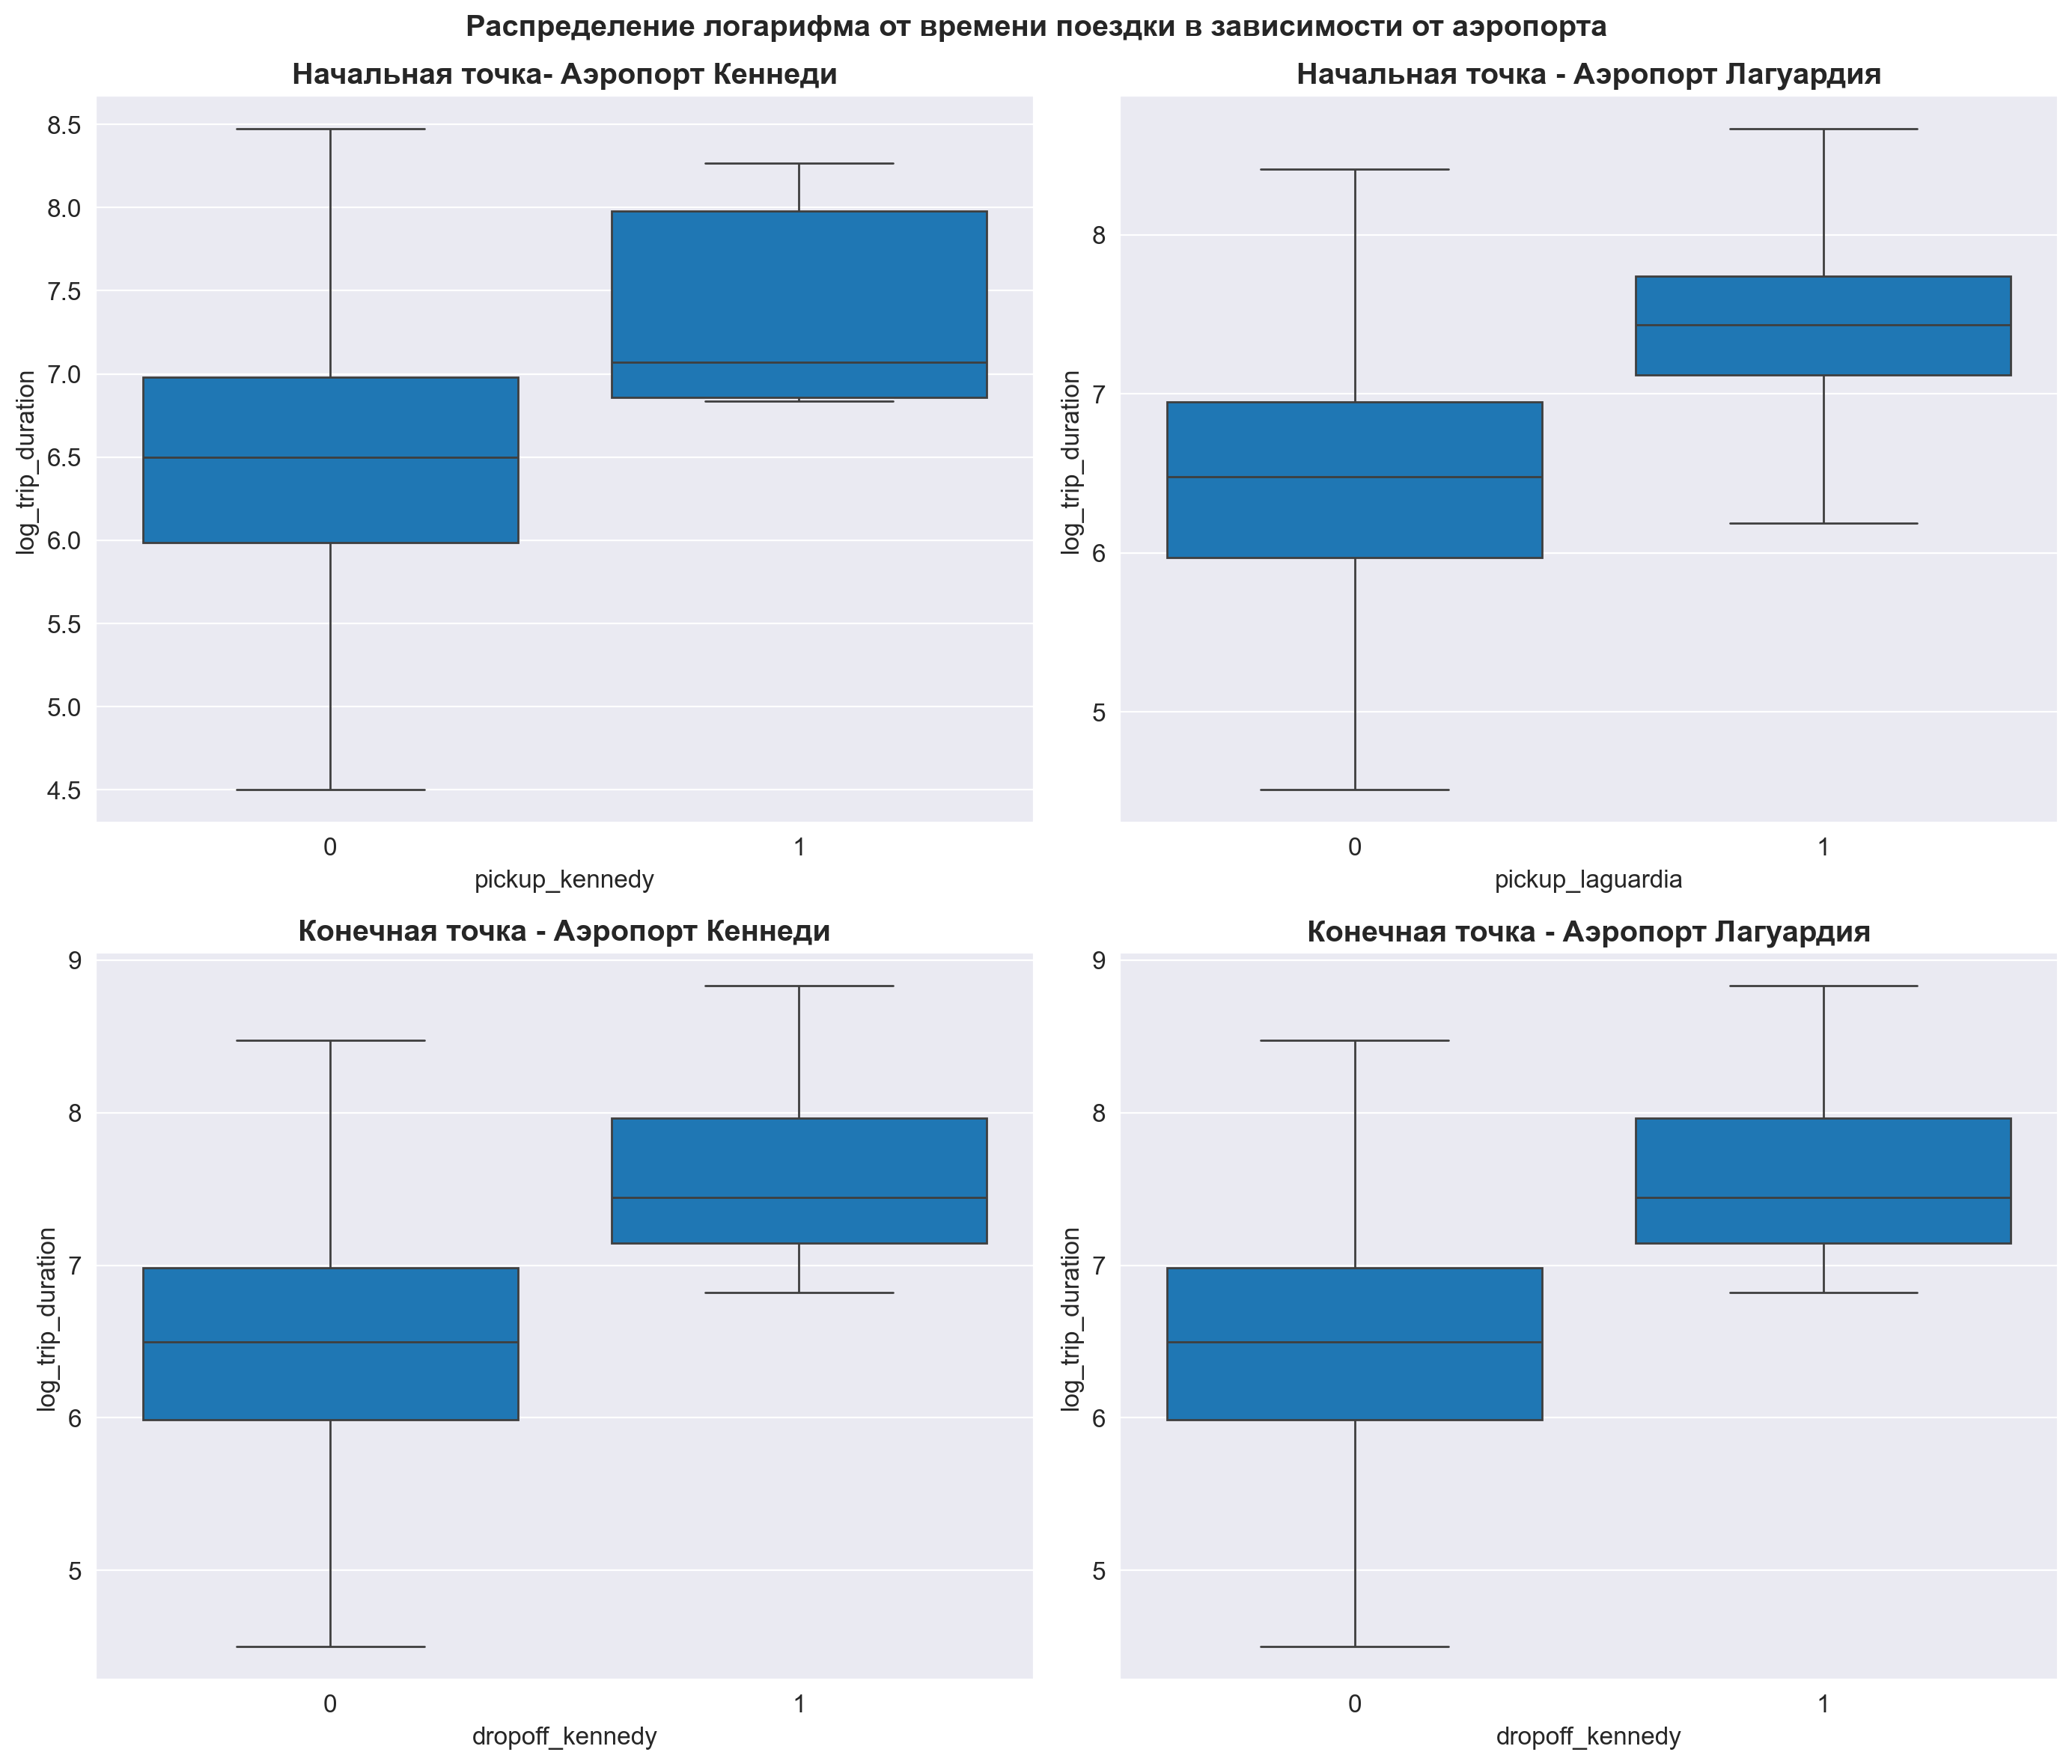

In [265]:
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
fig.suptitle('Распределение логарифма от времени поездки в зависимости от аэропорта', weight = 'bold', )

sns.boxplot(data = df_train_copy,
            x = 'pickup_kennedy',
            y = 'log_trip_duration',
            showfliers = False,
            saturation = 1,
            ax = ax[0,0]).set_title('Начальная точка- Аэропорт Кеннеди', weight = 'bold')

sns.boxplot(data = df_train_copy,
            x = 'pickup_laguardia',
            y = 'log_trip_duration',
            showfliers = False,
            saturation = 1,
            ax = ax[0,1]).set_title('Начальная точка - Аэропорт Лагуардия', weight = 'bold')

sns.boxplot(data = df_train_copy,
            x = 'dropoff_kennedy',
            y = 'log_trip_duration',
            showfliers = False,
            saturation = 1,
            ax = ax[1,0]).set_title('Конечная точка - Аэропорт Кеннеди', weight = 'bold')

sns.boxplot(data = df_train_copy,
            x = 'dropoff_kennedy',
            y = 'log_trip_duration',
            showfliers = False,
            saturation = 1,
            ax = ax[1,1]).set_title('Конечная точка - Аэропорт Лагуардия', weight = 'bold')


plt.tight_layout()

Ящики показывают, что выбранные признаки наличия рядом аэропортов - хорошие. В зависимости от признаков квартили сильно различаются.

Text(0.5, 1.0, 'Нет пробок')

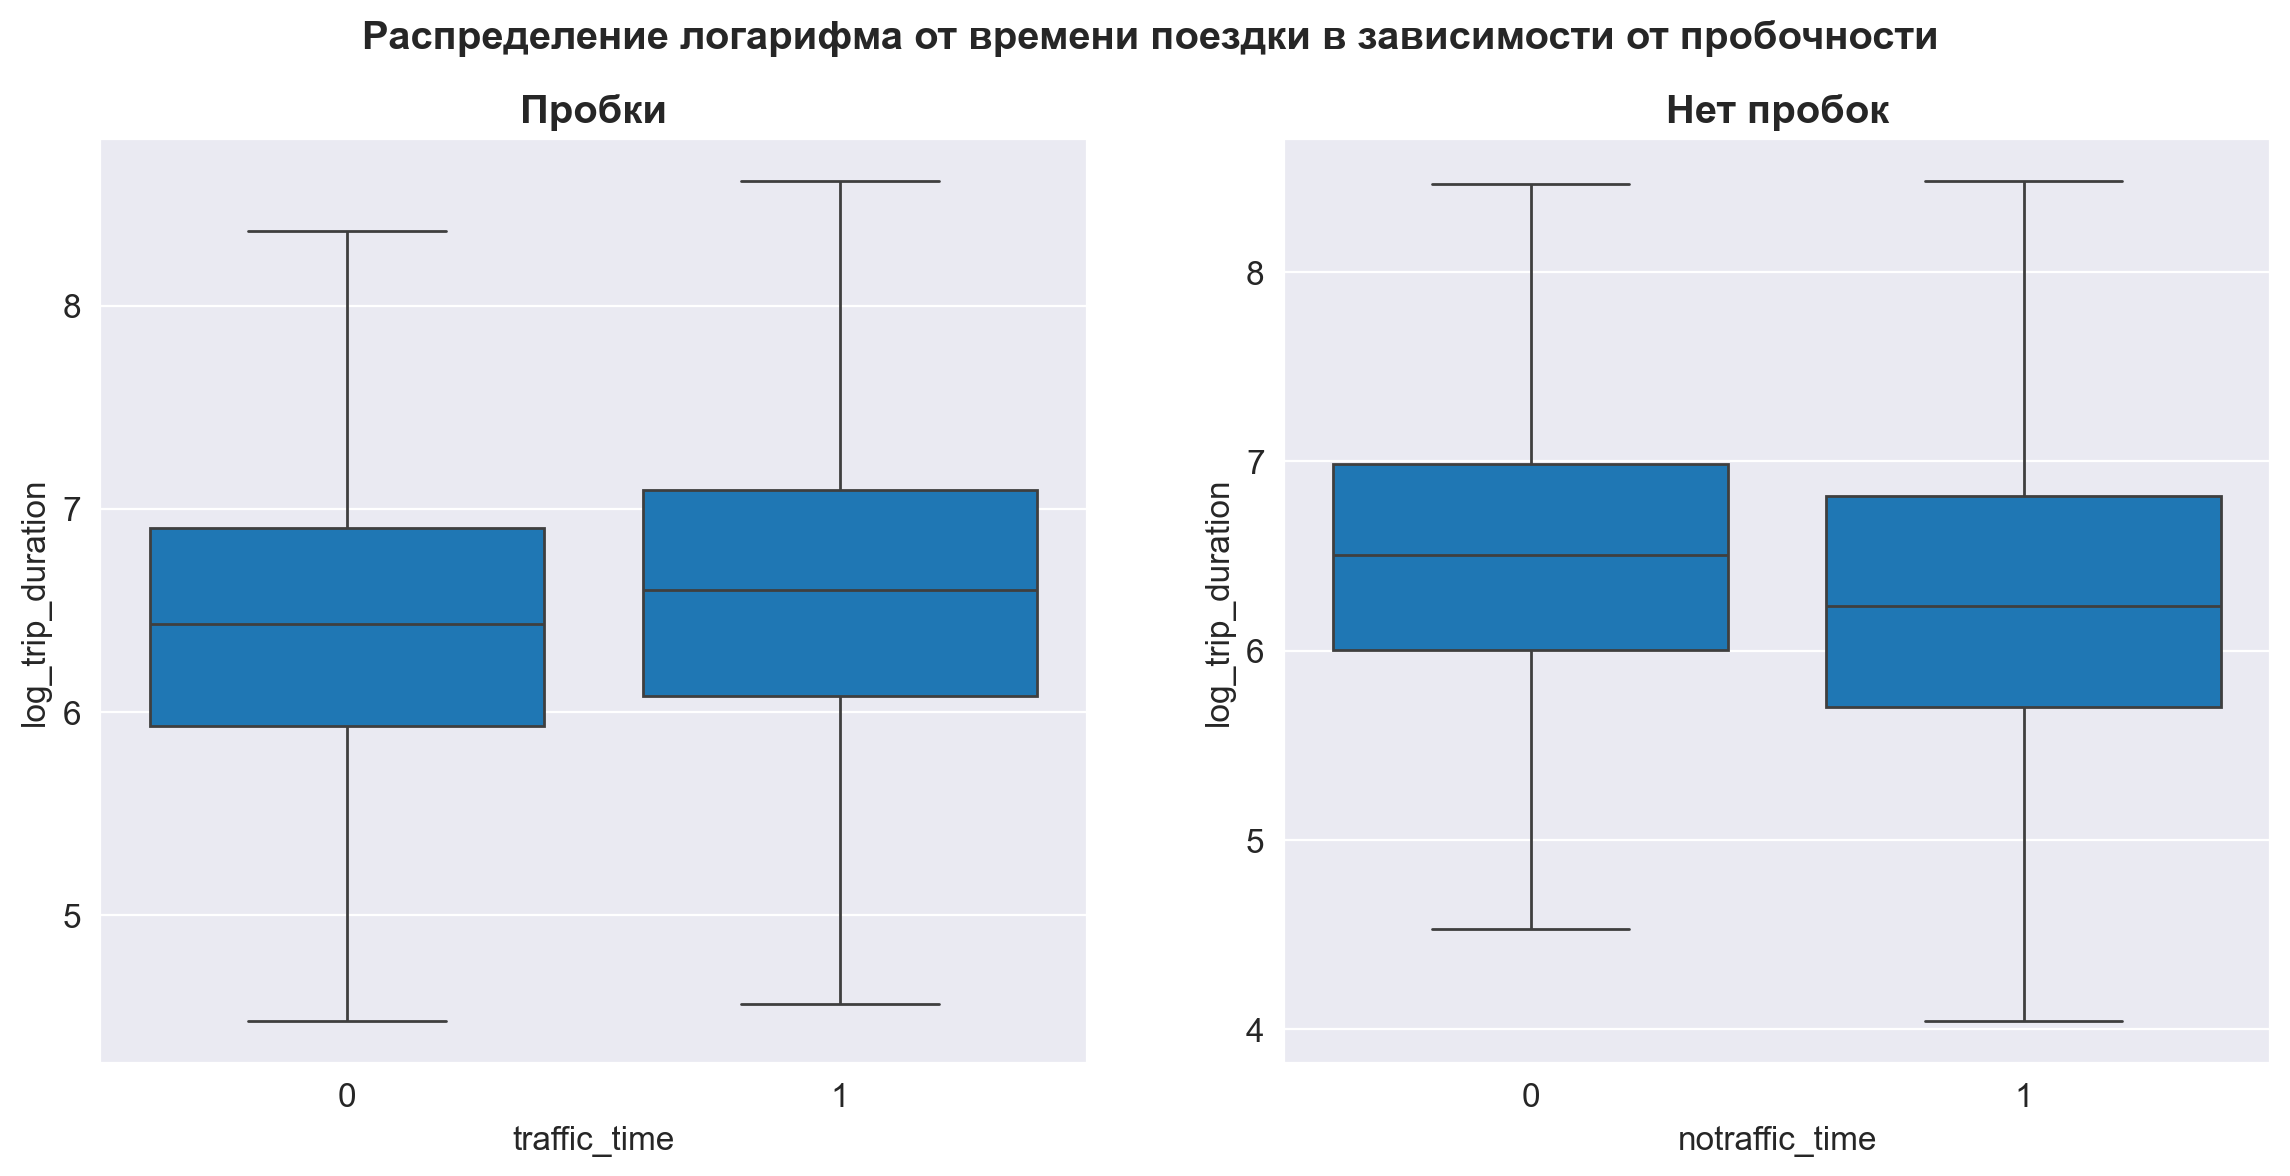

In [271]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
fig.suptitle('Распределение логарифма от времени поездки в зависимости от пробочности', weight = 'bold', )

sns.boxplot(data = df_train_copy,
            x = 'traffic_time',
            y = 'log_trip_duration',
            showfliers = False,
            saturation = 1,
            ax = ax[0]).set_title('Пробки', weight = 'bold')

sns.boxplot(data = df_train_copy,
            x = 'notraffic_time',
            y = 'log_trip_duration',
            showfliers = False,
            saturation = 1,
            ax = ax[1]).set_title('Нет пробок', weight = 'bold')

А вот признак пробочно/непробочно - так себе. В зависимости от признаков квартили мало различаются.

Чтобы использовать координаты для постоения регрессий разобьем область с наибольшим числом поездок на клеточки. Каждой точке-поезде сопоставим клеточку, в которой она лежит. Тем, кто никуда не попал присвоим значение -1. Ниже будет визуализация, чтобы было понятно, о чем речь

In [300]:
from sklearn.base import BaseEstimator, TransformerMixin

    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features = []):
        self.features = features
        self.epsilon = 0.05
        pass
    
    def show_map(self, X):
        nrows=5
        ncols=4
        self.nrows = nrows
        self.ncols = ncols
        location = (X['pickup_latitude'].mean(), X['pickup_longitude'].mean())
        m = folium.Map(location=location, width = 1250, height = 800, zoom_start = 12.4) 

        lat_points = list(np.linspace(self.min_latitude, self.max_latitude, num = self.nrows + 1))
        lon_points = list(np.linspace(self.min_longitude, self.max_longitude, num = self.ncols + 1))

        for i in range(self.nrows + 1):
            folium.PolyLine([(lat_points[i], self.min_longitude), (lat_points[i], self.max_longitude)], color='red').add_to(m)
        for j in range(self.ncols + 1):
            folium.PolyLine([(self.min_latitude, lon_points[j]), (self.max_latitude, lon_points[j])], color='red').add_to(m)

        for _, row in X.iterrows():
          folium.Circle(
              radius=50,
              location=(row['pickup_latitude'], row['pickup_longitude']),
              color= 'blue',
              fill_color= 'blue',
              fill=True
          ).add_to(m)

        for _, row in X.iterrows():
          folium.Circle(
              radius=50,
              location=(row['dropoff_latitude'], row['dropoff_longitude']),
              color= 'green',
              fill_color= 'green',
              fill=True
          ).add_to(m)

        return m

    def fit(self, X=None, y=None):
        self.min_longitude = X['pickup_longitude'].quantile(self.epsilon)
        self.max_longitude = X['pickup_longitude'].quantile(1 - self.epsilon)
        self.min_latitude = X['pickup_latitude'].quantile(self.epsilon)
        self.max_latitude = X['pickup_latitude'].quantile(1 - self.epsilon)
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        def create_cell(category):
            if category == 'pickup':
                long_cell = (X_copy['pickup_longitude'] - self.min_longitude) * 3 // (self.max_longitude - self.min_longitude)
                lat_cell = ((X_copy['pickup_latitude'] - self.min_latitude) * 4 // (self.max_latitude - self.min_latitude)) * 3
            elif category == 'dropoff':
                long_cell = (X_copy['dropoff_longitude'] - self.min_longitude) * 3 // (self.max_longitude - self.min_longitude)
                lat_cell = ((X_copy['dropoff_latitude'] - self.min_latitude) * 4 // (self.max_latitude - self.min_latitude)) * 3
            return long_cell + lat_cell
            
        def inner_condition(category):
            if category == 'pickup':
                mask = (
                (X_copy['pickup_longitude'] >= self.min_longitude) & 
                (X_copy['pickup_longitude'] <= self.max_longitude) &
                (X_copy['pickup_latitude'] >= self.min_latitude) & 
                (X_copy['pickup_latitude'] <= self.max_latitude)
                )
            elif category == 'dropoff':
                mask = (
                (X_copy['dropoff_longitude'] >= self.min_longitude) & 
                (X_copy['dropoff_longitude'] <= self.max_longitude) &
                (X_copy['dropoff_latitude'] >= self.min_latitude) & 
                (X_copy['dropoff_latitude'] <= self.max_latitude)
                )
            return mask

        X_copy['pickup_cell'] = create_cell(category = 'pickup')
        X_copy['pickup_cell'] = np.where(inner_condition(category = 'pickup'), X_copy['pickup_cell'], -1)
        X_copy['dropoff_cell'] = create_cell(category = 'dropoff')
        X_copy['dropoff_cell'] = np.where(inner_condition(category = 'dropoff'), X_copy['dropoff_cell'], -1)
        return X_copy

In [301]:
sample = df_train_copy.sample(1000)
sample_transformer = MapGridTransformer()
sample_transformer.fit(sample)
sample_transformed_data = sample_transformer.transform(sample)
sample_transformer.show_map(sample)

Обучаем `Ridge` регрессию

In [273]:
df_train2 = df_train_copy.copy()
df_test2 = df_test_copy.copy()
df_train2['pickup_cell'] = 0
df_test2['pickup_cell'] = 0
df_train2['dropoff_cell'] = 0
df_test2['dropoff_cell'] = 0

y_train2 = df_train2['log_trip_duration']
y_test2 = df_test2['log_trip_duration']

In [312]:
categorical_features = ['traffic_time', 'notraffic_time', 'pickup_laguardia', 'dropoff_laguardia', 'pickup_kennedy', 'dropoff_kennedy',
               'day_of_week', 'pickup_cell', 'dropoff_cell']
numeric_features = ['log_haversine', 'year_day', 'pickup_hour']

In [313]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

ridge_pipeline = Pipeline(steps=[
    ('cell_transformation', MapGridTransformer()),
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = ridge_pipeline.fit(df_train2, y_train)
y_train_predict = model.predict(df_train2)
y_predict = model.predict(df_test2)
print("Test RMSLE = %.4f" % rmsle(y_test2, y_predict))
print("Train RMSLE = %.4f" % rmsle(y_train2, y_train_predict))

Test RMSLE = 0.4823
Train RMSLE = 0.4829


In [315]:
y = df_train2['log_trip_duration']
df_train2['MSLE'] = (y_train - y_train_pred)**2

Text(0.5, 1.0, 'Распределение log_trip_duration на тестовой выборке')

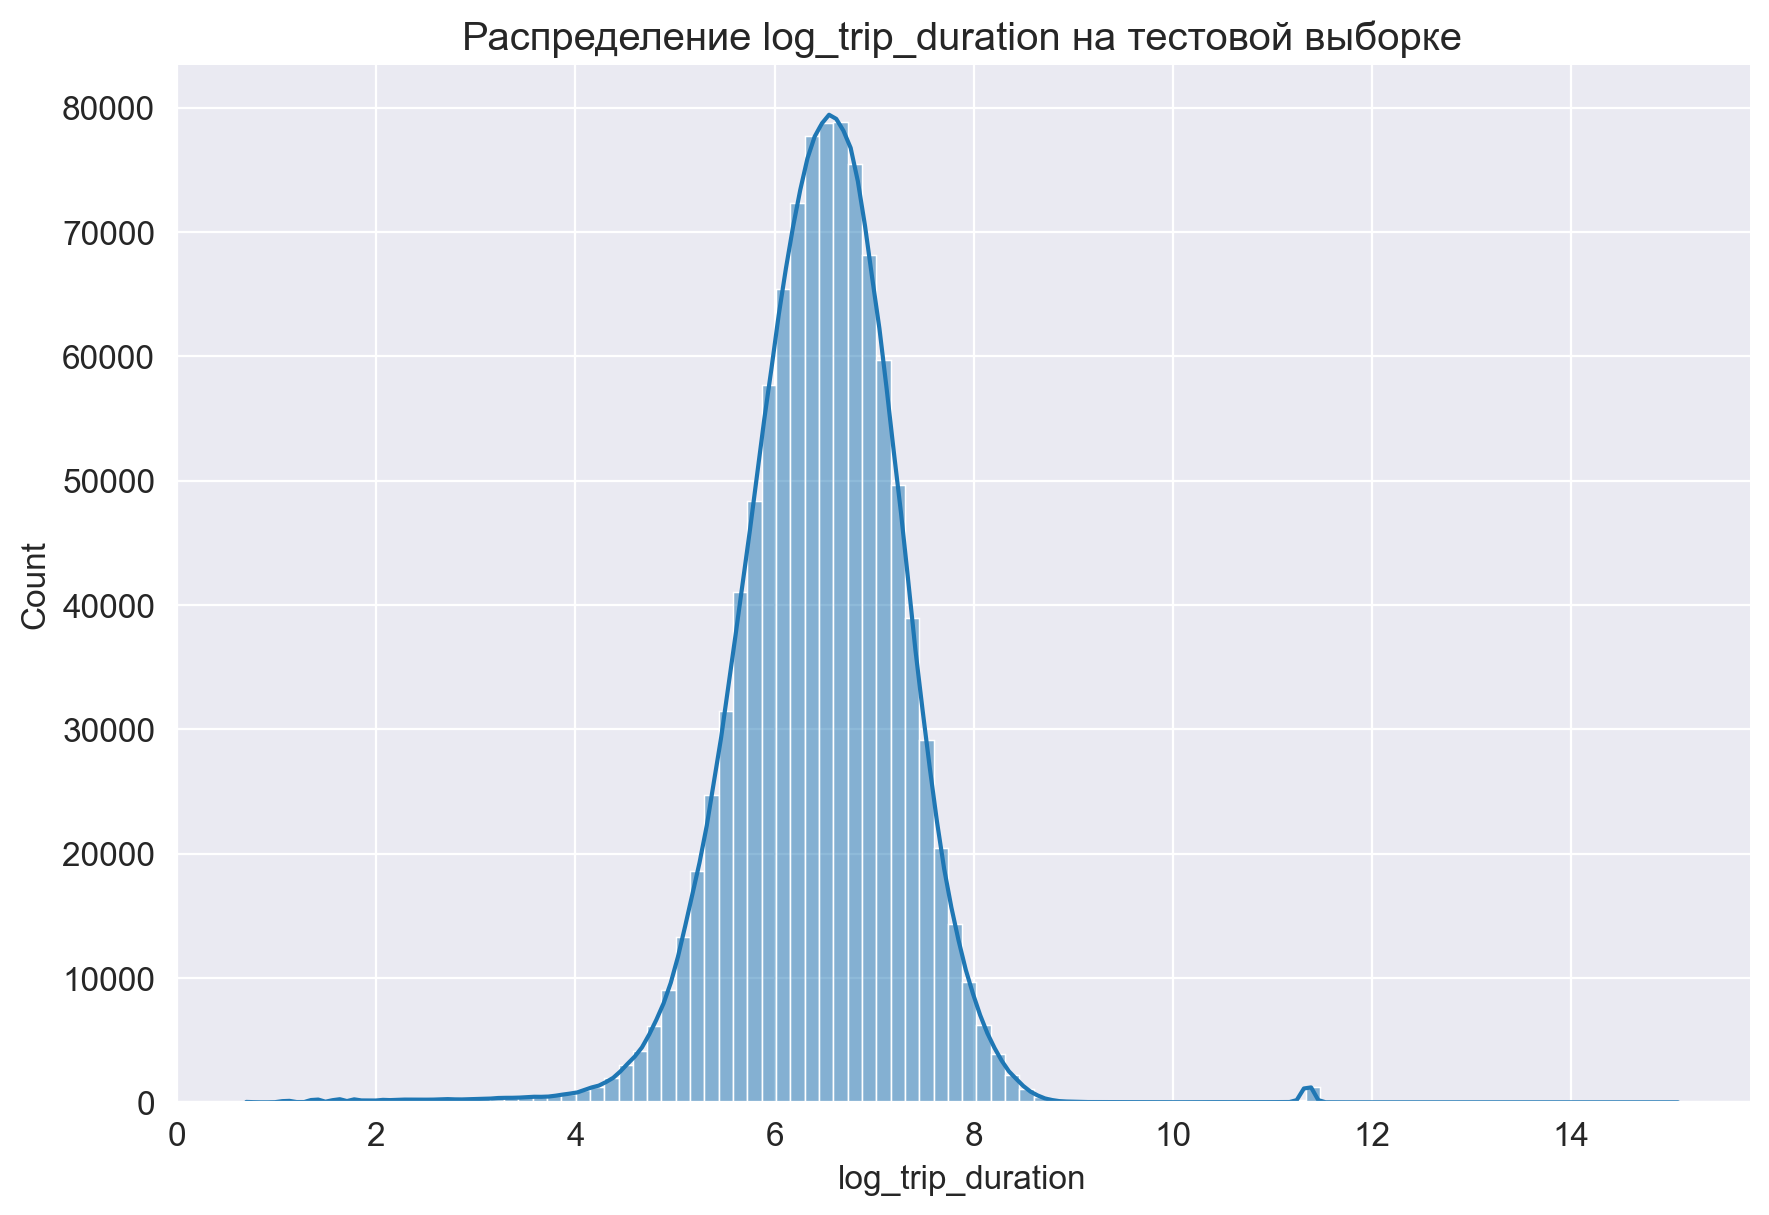

In [316]:
sns.displot(x = y_train,
            kde=True,
            bins=100,
            height=6,
            aspect=1.5);
plt.title('Распределение log_trip_duration на тестовой выборке')

Text(0.5, 1.0, 'Распределение log_haversine на тестовой выборке')

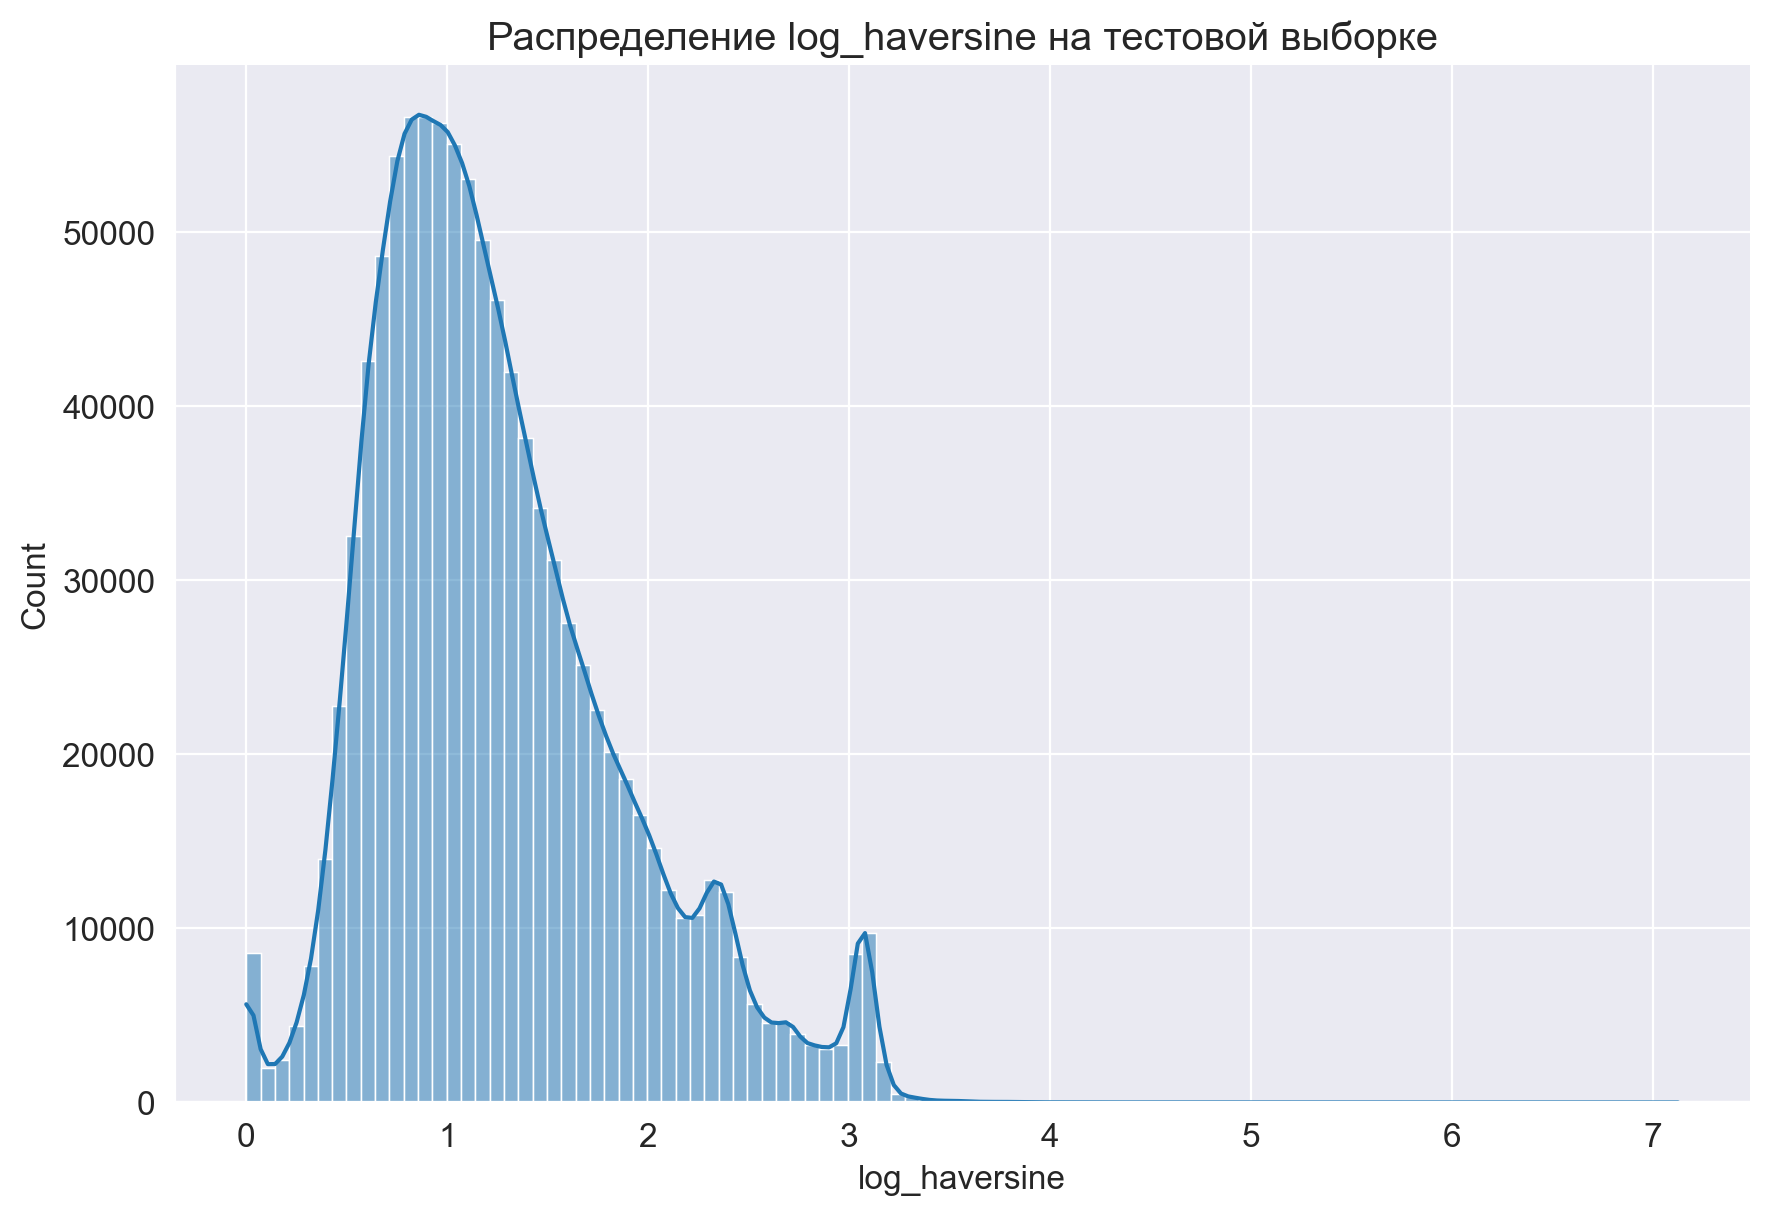

In [317]:
sns.displot(x = df_train2['log_haversine'],
            kde=True,
            bins=100,
            height=6,
            aspect=1.5);
plt.title('Распределение log_haversine на тестовой выборке')